# TASK 1: Classification

## Define:
1. Objectives: Build a classification model to predict stroke (= 1 if a person had a stroke else 0).
2. Data sources: https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset
3. Strategy: Conclude on one optimal model by trying out the different algorithms used in class.

In [12]:
# Import key libraries
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ydata_profiling as profiling
import sqlite3
from sklearn.linear_model import LogisticRegressionCV, RidgeClassifierCV, Perceptron, LogisticRegression
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, auc, roc_curve, RocCurveDisplay, PrecisionRecallDisplay, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.feature_selection import SelectKBest, chi2, f_classif, SequentialFeatureSelector
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier

## Get data from database

In [3]:
# Establish connection with project.db
sqlite_db = r"D:\git_repo_IO_mini_project2\IOD_mini_project2\Database\project.db" # rename root directory to your own directory
conn = sqlite3.connect(sqlite_db)

In [4]:
df_healthcare = pd.read_sql_query("SELECT * FROM healthcare_raw",con=conn)
df_healthcare.drop(columns=["index"],inplace=True)
df_healthcare.head()

id  gender   age  hypertension  heart_disease ever_married  \
0   9046    Male  67.0             0              1          Yes   
1  51676  Female  61.0             0              0          Yes   
2  31112    Male  80.0             0              1          Yes   
3  60182  Female  49.0             0              0          Yes   
4   1665  Female  79.0             1              0          Yes   

       work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
0        Private          Urban             228.69  36.6  formerly smoked   
1  Self-employed          Rural             202.21   NaN     never smoked   
2        Private          Rural             105.92  32.5     never smoked   
3        Private          Urban             171.23  34.4           smokes   
4  Self-employed          Rural             174.12  24.0     never smoked   

   stroke  
0       1  
1       1  
2       1  
3       1  
4       1

## Exploratory Data Analysis (EDA)

In [4]:
prof = profiling.ProfileReport(df_healthcare)
prof.to_file("healthcare_profiling.html")

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 179.74it/s]


In [4]:
df_healthcare.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [4]:
df_healthcare.describe()

id          age  hypertension  heart_disease  \
count   5110.000000  5110.000000   5110.000000    5110.000000   
mean   36517.829354    43.226614      0.097456       0.054012   
std    21161.721625    22.612647      0.296607       0.226063   
min       67.000000     0.080000      0.000000       0.000000   
25%    17741.250000    25.000000      0.000000       0.000000   
50%    36932.000000    45.000000      0.000000       0.000000   
75%    54682.000000    61.000000      0.000000       0.000000   
max    72940.000000    82.000000      1.000000       1.000000   

       avg_glucose_level          bmi       stroke  
count        5110.000000  4909.000000  5110.000000  
mean          106.147677    28.893237     0.048728  
std            45.283560     7.854067     0.215320  
min            55.120000    10.300000     0.000000  
25%            77.245000    23.500000     0.000000  
50%            91.885000    28.100000     0.000000  
75%           114.090000    33.100000     0.000000  
max           271.740000    97.600000     1.000000

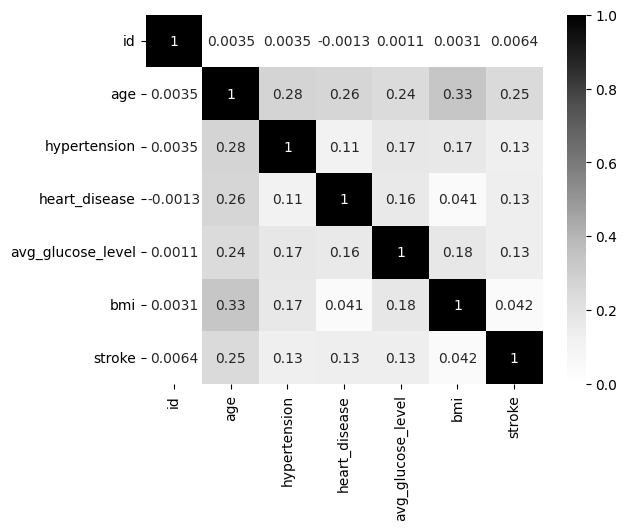

In [5]:
sns.heatmap(df_healthcare.corr(numeric_only=True),annot=True,cmap="Greys")
plt.show()

### EDA pairplot

C:\Users\Admin\anaconda3\envs\IOD_mini_project2\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


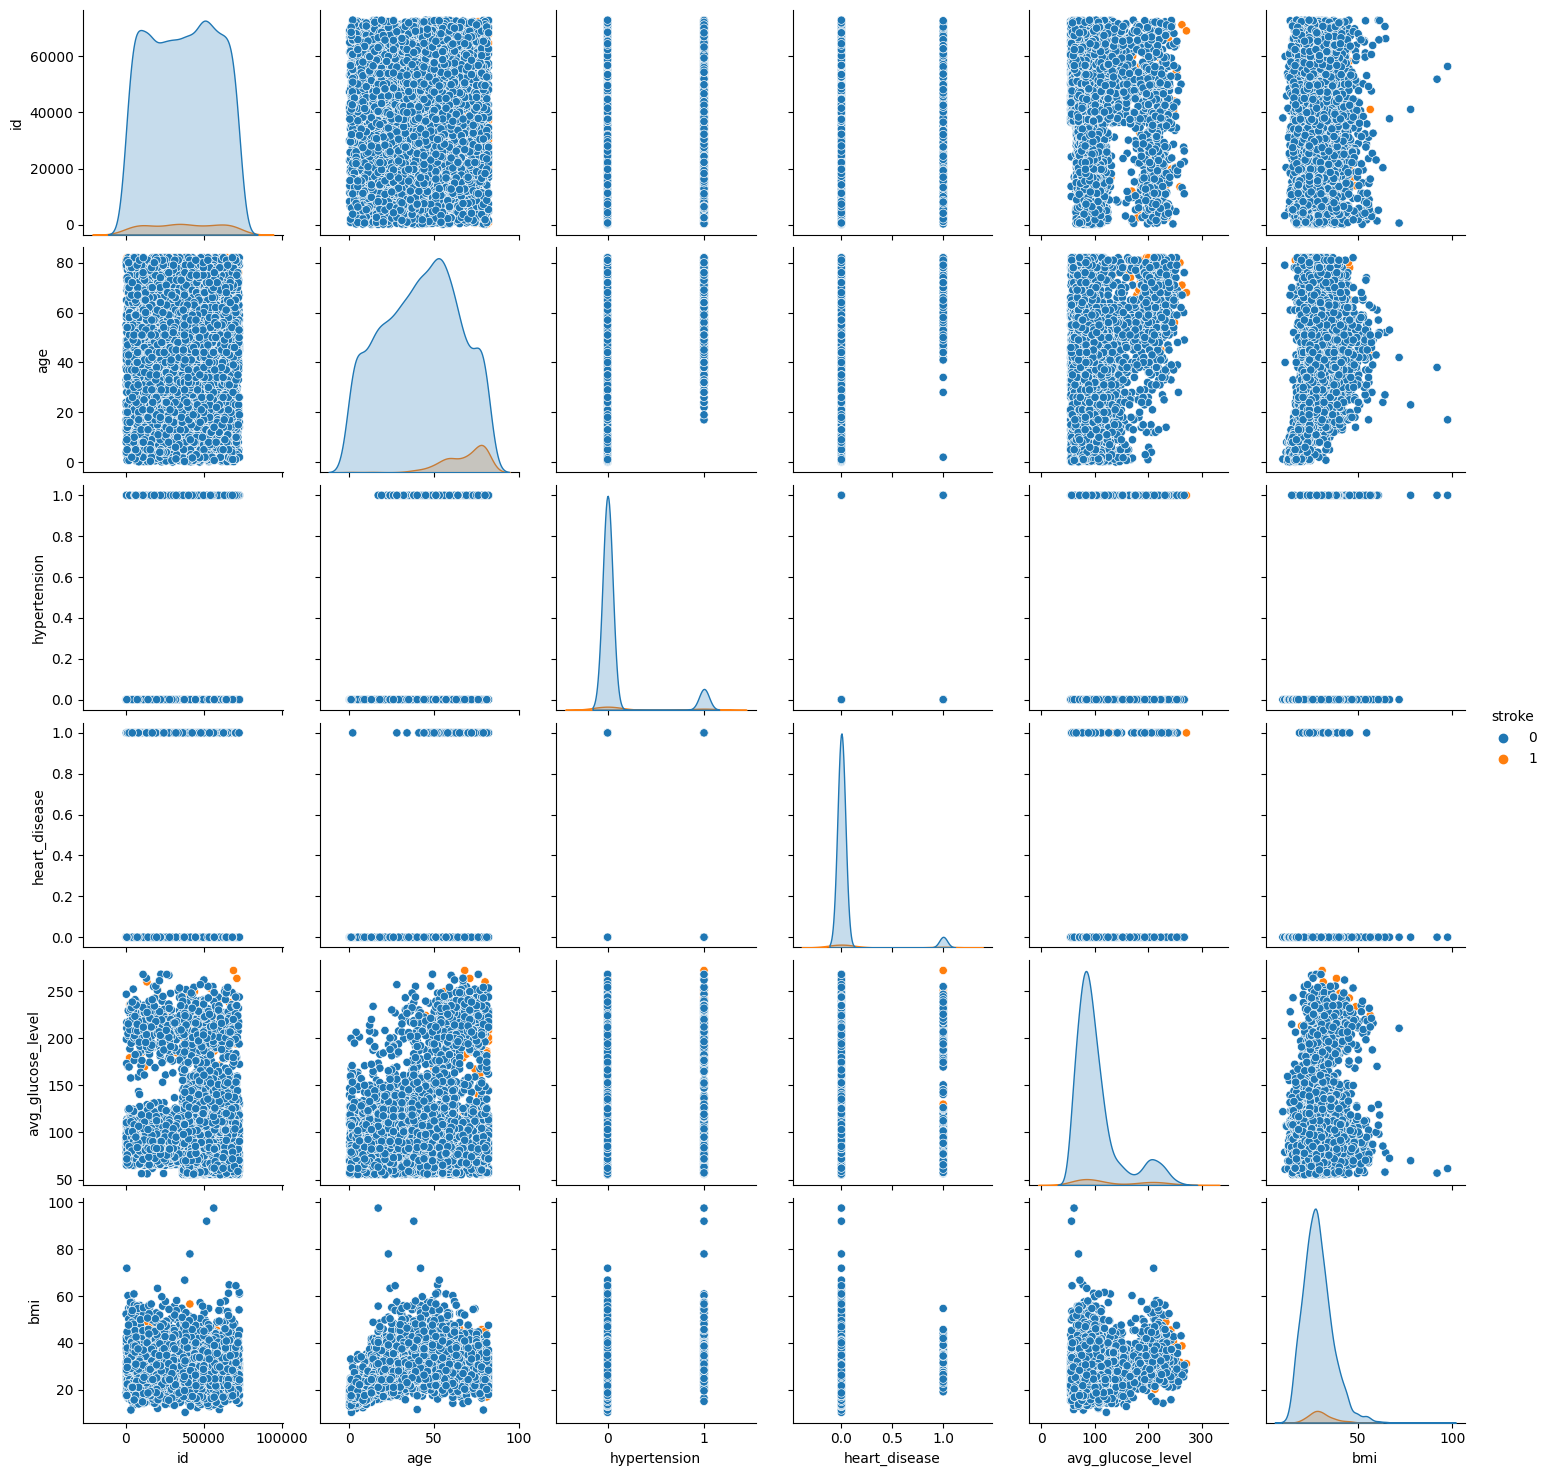

In [14]:
sns.pairplot(data=df_healthcare,hue="stroke",dropna=True)
plt.show()

C:\Users\Admin\anaconda3\envs\IOD_mini_project2\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


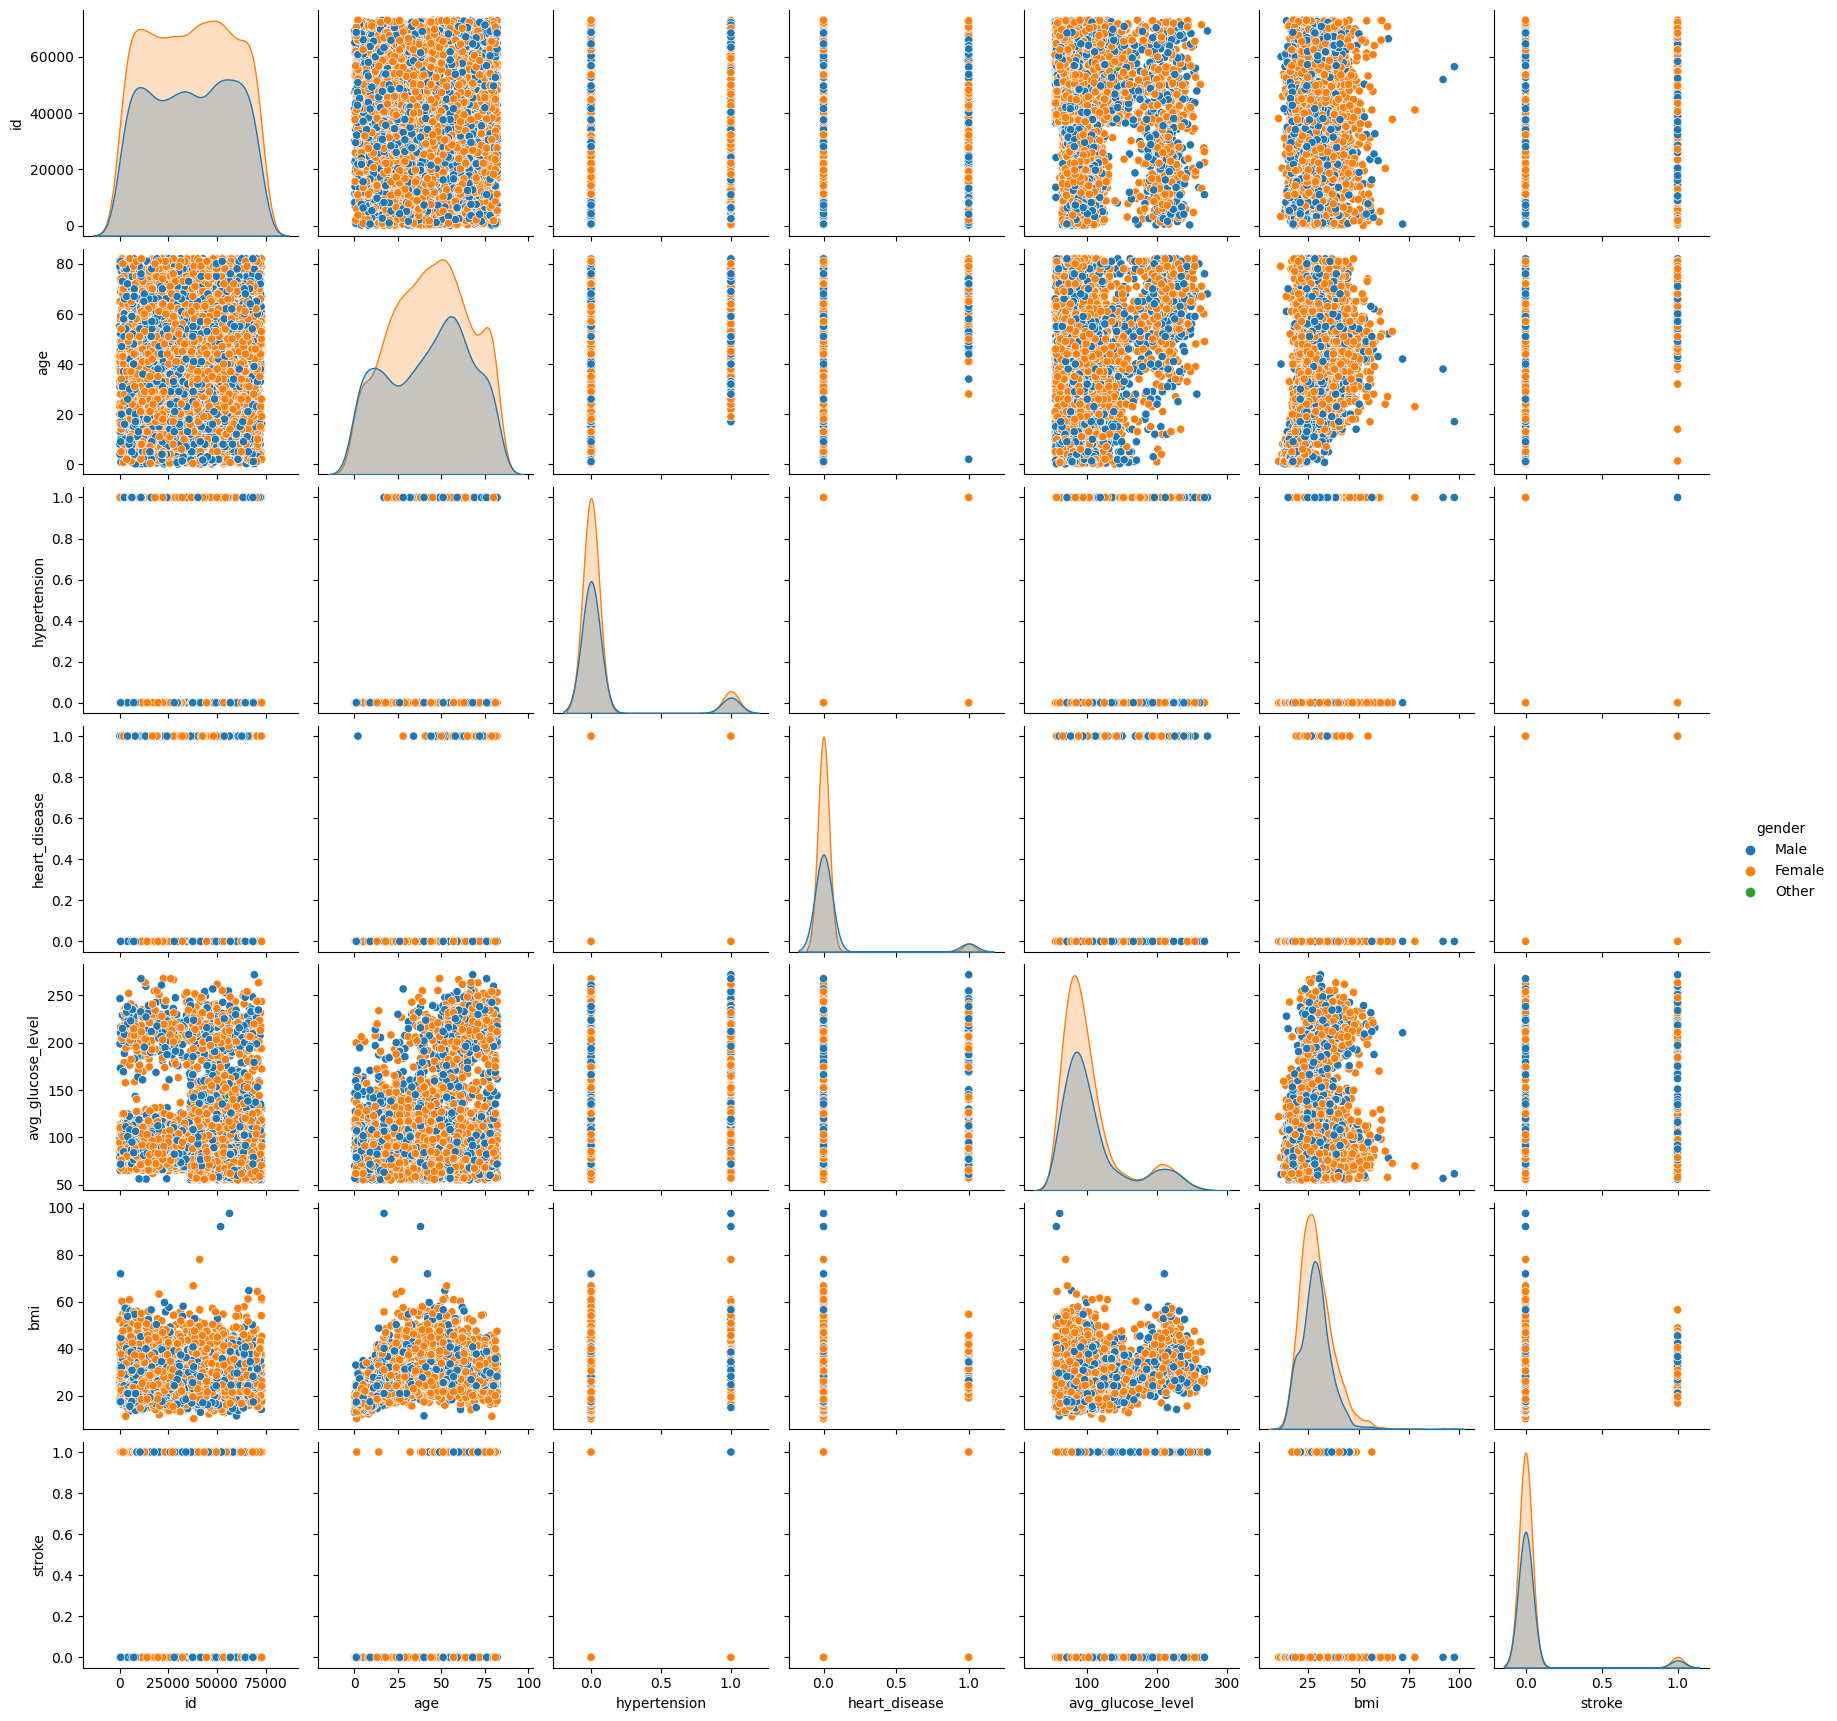

In [15]:
sns.pairplot(data=df_healthcare,hue="gender",dropna=True)
plt.show()

C:\Users\Admin\anaconda3\envs\IOD_mini_project2\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


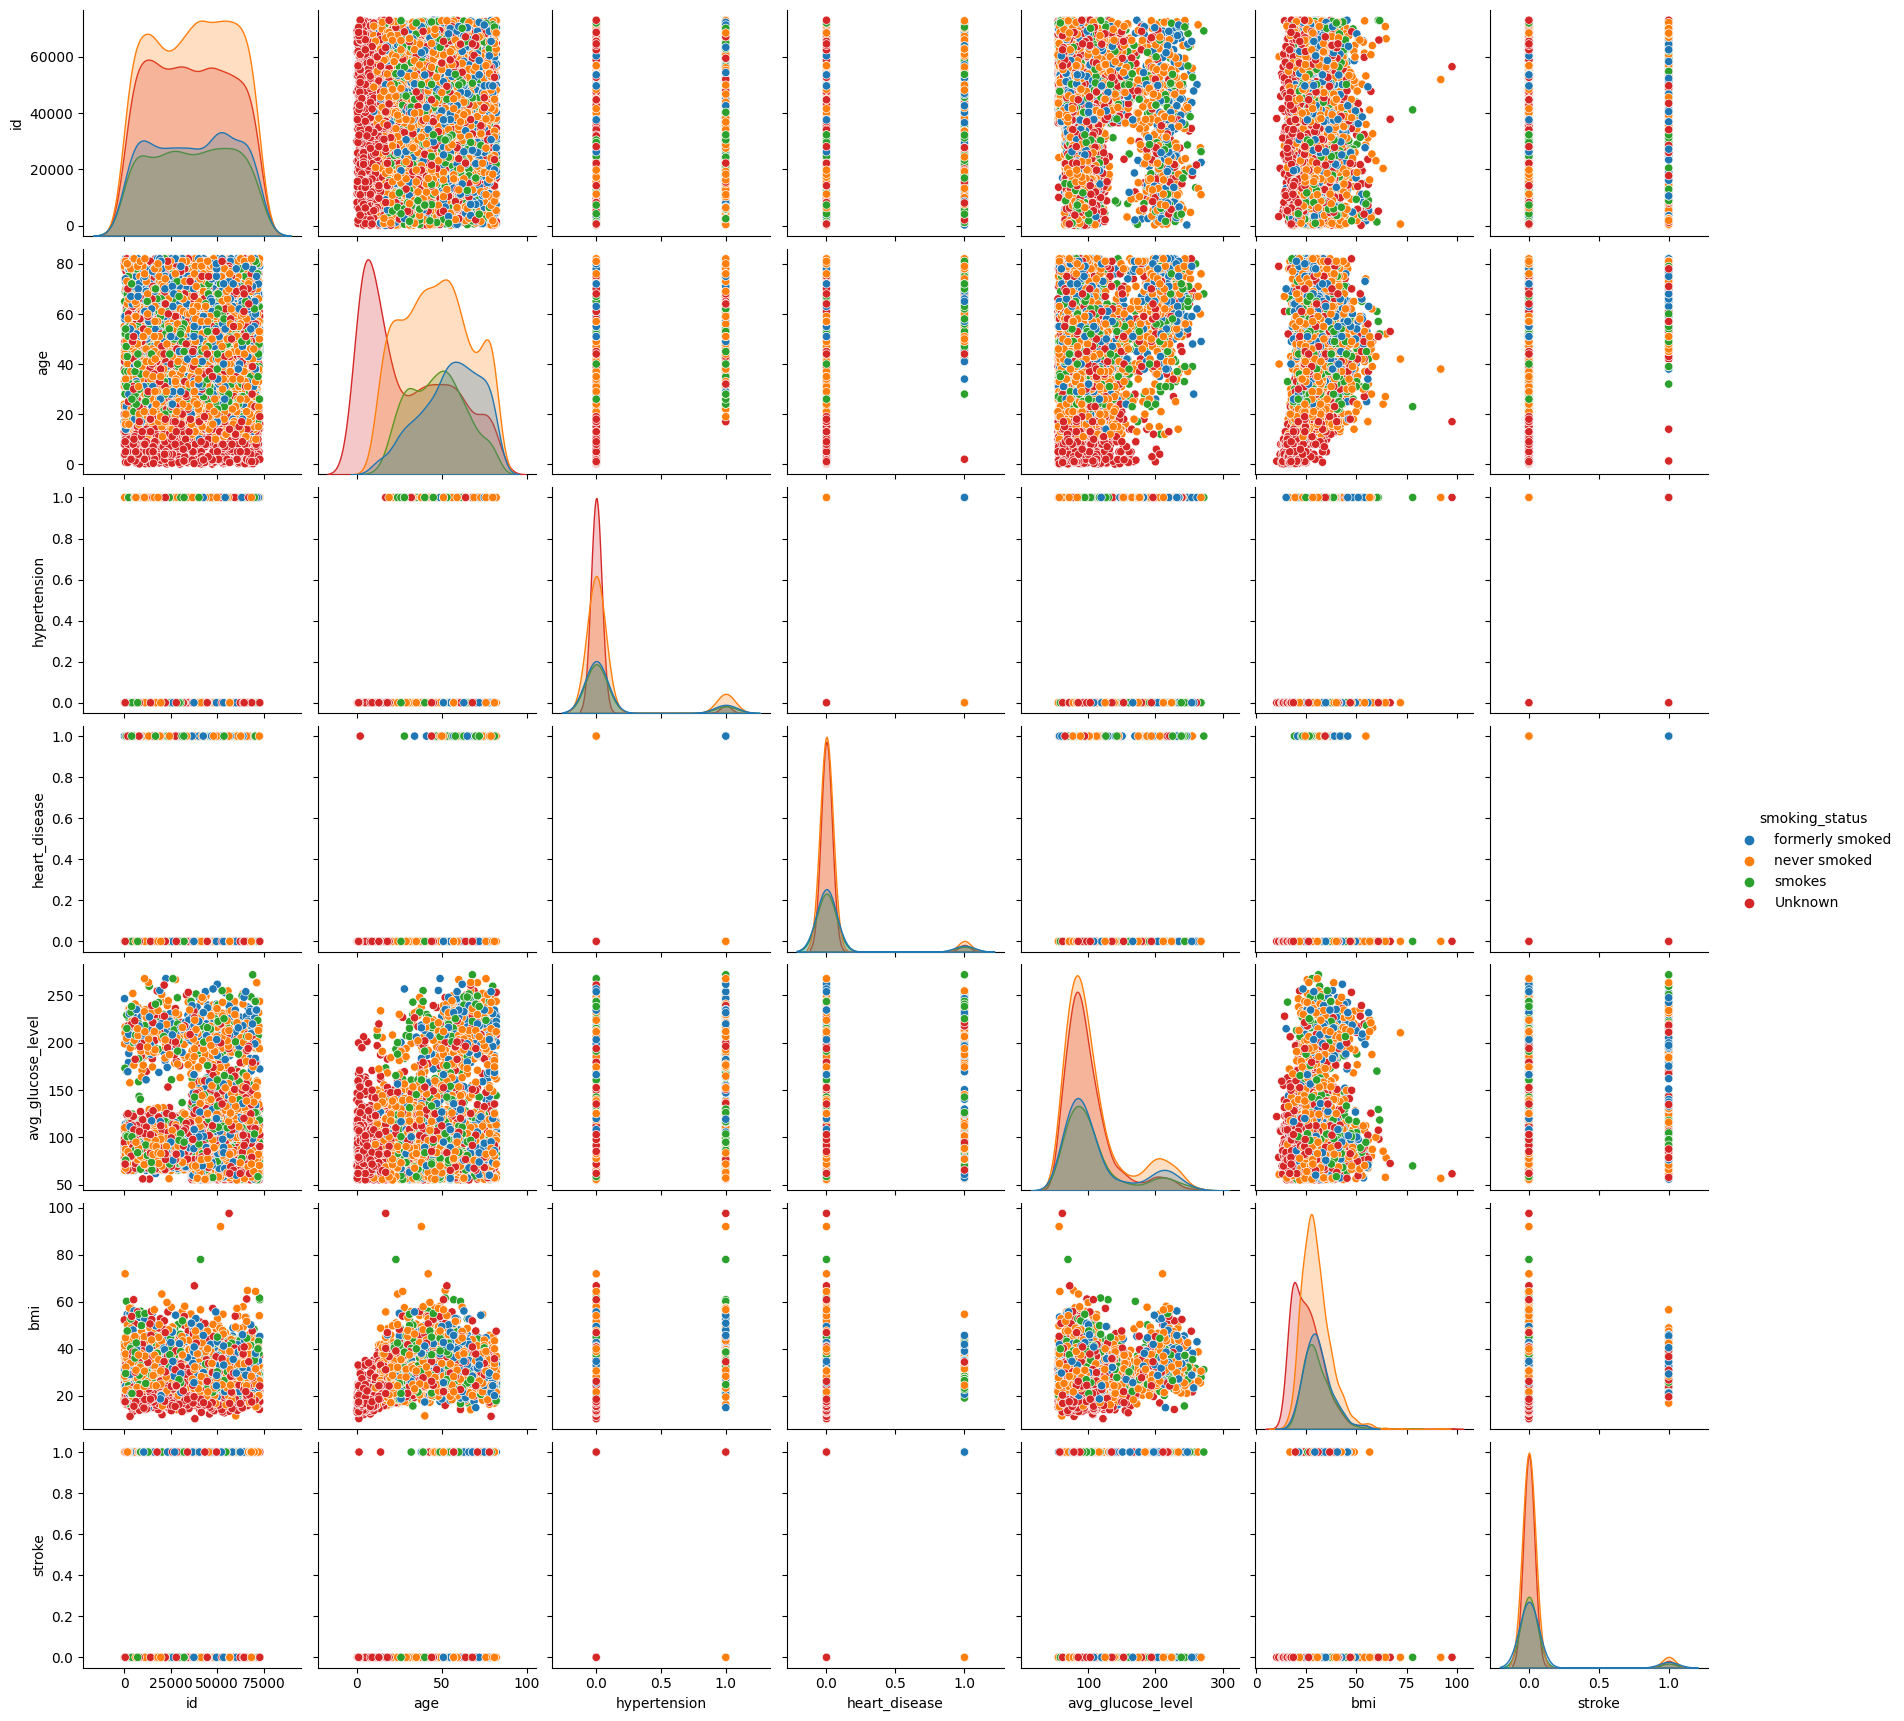

In [16]:
sns.pairplot(data=df_healthcare,hue="smoking_status",dropna=True)
plt.show()

## Preprocessing

In [6]:
# Get sum of null values for each feature
df_healthcare.isna().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [7]:
# min values of bmi and age looks wrong
print(df_healthcare.age.min()) # age of >1 years old in a dataset for stroke (double checked on google, children can suffer from stroke)
'''
Pediatric stroke affects 25 in 100,000 newborns and 12 in 100,000 children under 18 years of age.
Stroke is the sixth leading cause of death in children.
Children at risk of stroke include: Newborns, especially full-term infants.
'''
print(df_healthcare.bmi.min()) # bmi of ~10, to achieve this: weight ~30, height ~1.5-1.7 (double confirmed these rows are under "children" class)

0.08
10.3


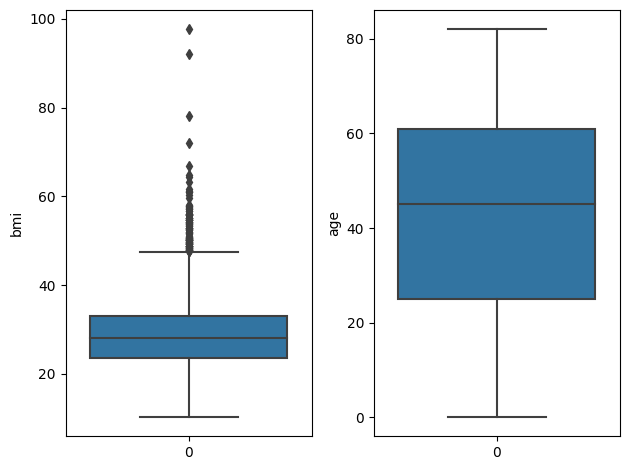

In [8]:
plt.subplot(121)
sns.boxplot(df_healthcare["bmi"])
plt.ylabel("bmi")
plt.subplot(122)
sns.boxplot(df_healthcare["age"])
plt.ylabel("age")
plt.tight_layout()
plt.show()

In [9]:
df_healthcare[df_healthcare["age"]<=18].head()

id  gender    age  hypertension  heart_disease ever_married  \
162  69768  Female   1.32             0              0           No   
245  49669  Female  14.00             0              0           No   
249  30669    Male   3.00             0              0           No   
251  16523  Female   8.00             0              0           No   
253  46136    Male  14.00             0              0           No   

        work_type Residence_type  avg_glucose_level   bmi smoking_status  \
162      children          Urban              70.37   NaN        Unknown   
245      children          Rural              57.93  30.9        Unknown   
249      children          Rural              95.12  18.0        Unknown   
251       Private          Urban             110.89  17.6        Unknown   
253  Never_worked          Rural             161.28  19.1        Unknown   

     stroke  
162       1  
245       1  
249       0  
251       0  
253       0

In [10]:
df_healthcare[(df_healthcare["bmi"] >= 9)&(df_healthcare["bmi"] <= 15)].head()

id  gender  age  hypertension  heart_disease ever_married work_type  \
425   6107  Female  5.0             0              0           No  children   
657  20364  Female  4.0             0              0           No  children   
684  53016  Female  1.8             0              0           No  children   
814  10324  Female  5.0             0              0           No  children   
922  45893  Female  8.0             0              0           No  children   

    Residence_type  avg_glucose_level   bmi smoking_status  stroke  
425          Urban              77.88  13.8        Unknown       0  
657          Urban             107.25  12.0        Unknown       0  
684          Urban             130.61  14.4        Unknown       0  
814          Urban              93.88  14.6        Unknown       0  
922          Urban             106.51  12.3        Unknown       0

In [5]:
df_healthcare_with_dummies = pd.get_dummies(df_healthcare,drop_first=True,dtype=int)
df_healthcare_with_dummies.head()

id   age  hypertension  heart_disease  avg_glucose_level   bmi  stroke  \
0   9046  67.0             0              1             228.69  36.6       1   
1  51676  61.0             0              0             202.21   NaN       1   
2  31112  80.0             0              1             105.92  32.5       1   
3  60182  49.0             0              0             171.23  34.4       1   
4   1665  79.0             1              0             174.12  24.0       1   

   gender_Male  gender_Other  ever_married_Yes  work_type_Never_worked  \
0            1             0                 1                       0   
1            0             0                 1                       0   
2            1             0                 1                       0   
3            0             0                 1                       0   
4            0             0                 1                       0   

   work_type_Private  work_type_Self-employed  work_type_children  \
0                  1                        0                   0   
1                  0                        1                   0   
2                  1                        0                   0   
3                  1                        0                   0   
4                  0                        1                   0   

   Residence_type_Urban  smoking_status_formerly smoked  \
0                     1                               1   
1                     0                               0   
2                     0                               0   
3                     1                               0   
4                     0                               0   

   smoking_status_never smoked  smoking_status_smokes  
0                            0                      0  
1                            1                      0  
2                            1                      0  
3                            0                      1  
4                            1                      0

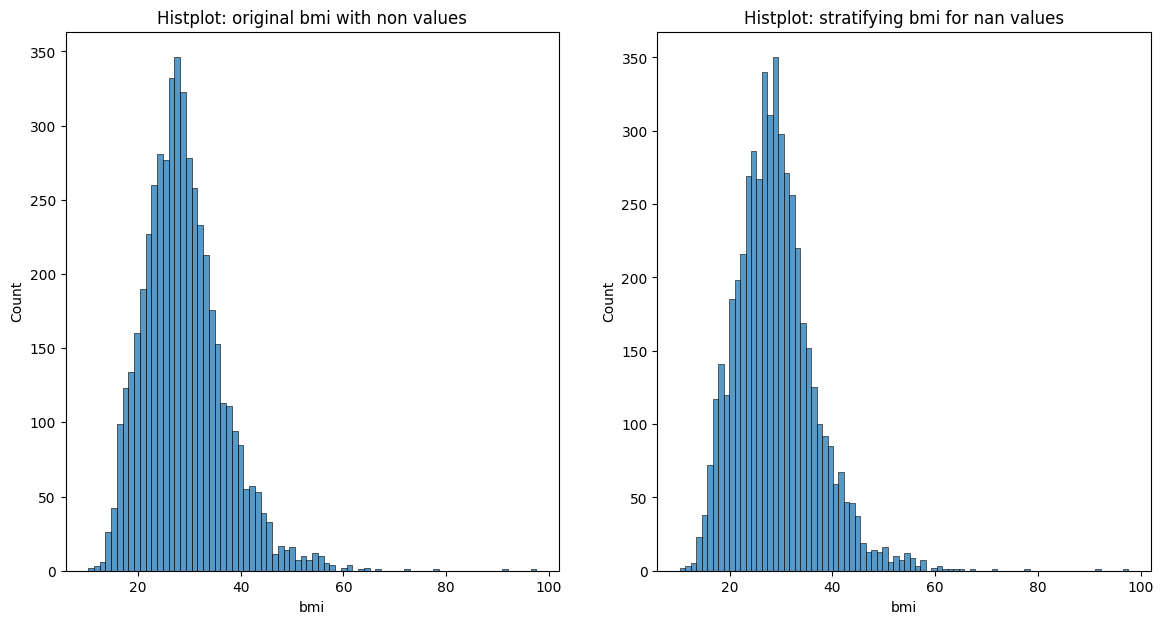

In [6]:
# stratifying bmi by the means of groups
# bmi - weight / height ** 2
# things that affects height and weight = [age,gender_Male,gender_Other,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children]
df_healthcare_with_dummies["bmi"] = df_healthcare_with_dummies[["bmi","age","gender_Male","gender_Other","work_type_Never_worked","work_type_Private","work_type_Self-employed","work_type_children"]].groupby(["age","gender_Male","gender_Other","work_type_Never_worked","work_type_Private","work_type_Self-employed","work_type_children"])["bmi"].transform(lambda x:x.fillna(x.mean()))
df_healthcare_with_dummies["bmi"] = df_healthcare_with_dummies["bmi"].replace(np.nan,df_healthcare_with_dummies["bmi"].mean())
# Get histplot of bmi
plt.figure(figsize=(14,7))
plt.subplot(121)
sns.histplot(df_healthcare["bmi"])
plt.title("Histplot: original bmi with non values")
plt.subplot(122)
sns.histplot(df_healthcare_with_dummies["bmi"])
plt.title("Histplot: stratifying bmi for nan values")
plt.show()

In [7]:
df_healthcare_with_dummies.isna().sum()

id                                0
age                               0
hypertension                      0
heart_disease                     0
avg_glucose_level                 0
bmi                               0
stroke                            0
gender_Male                       0
gender_Other                      0
ever_married_Yes                  0
work_type_Never_worked            0
work_type_Private                 0
work_type_Self-employed           0
work_type_children                0
Residence_type_Urban              0
smoking_status_formerly smoked    0
smoking_status_never smoked       0
smoking_status_smokes             0
dtype: int64

In [8]:
print(df_healthcare.bmi.mean())
print(df_healthcare_with_dummies.bmi.mean())

28.893236911794666
28.92462277999177


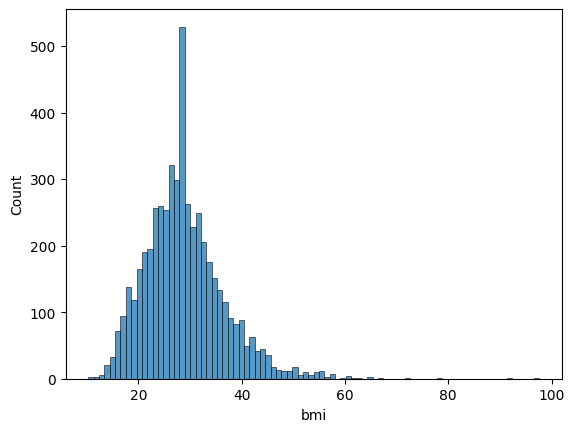

28.893236911794663


In [9]:
# Replace nan values with mean as estimate
df_healthcare_mean_bmi = df_healthcare.copy()
df_healthcare_mean_bmi["bmi"] = df_healthcare_mean_bmi["bmi"].replace(np.nan,df_healthcare_mean_bmi["bmi"].mean())
sns.histplot(df_healthcare_mean_bmi["bmi"])
plt.show()
print(df_healthcare_mean_bmi.bmi.mean())

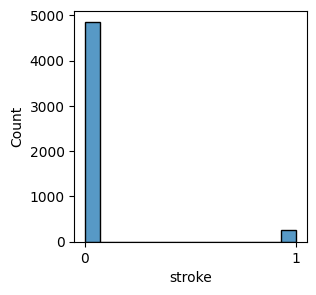

In [207]:
# Define predictor and target variables
list_pred_col = df_healthcare_with_dummies.columns.tolist()
list_pred_col.remove("stroke") # excluding target variable
list_pred_col.remove("id") # excluding as it has no effect with stroke
list_pred_col.remove("ever_married_Yes") # excluding as it has no effect with stroke
# trying rest of the features
X = df_healthcare_with_dummies[list_pred_col]
y = df_healthcare_with_dummies["stroke"]

plt.figure(figsize=(3,3))
plt.xticks(ticks=np.arange(0,2,1))
sns.histplot(y)
plt.show()

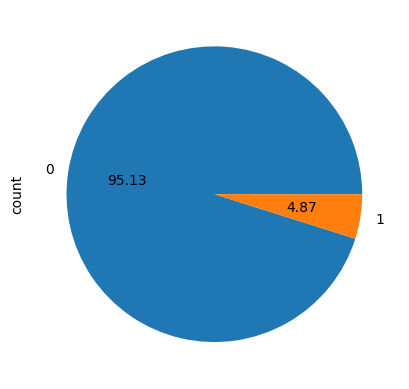

In [333]:
y.value_counts().plot.pie(autopct="%.2f")
plt.show()

In [9]:
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler

ros = RandomOverSampler(random_state=23)
X_ros, y_ros = ros.fit_resample(X_train,y_train)

smote = SMOTE(random_state=23)
X_smote, y_smote = smote.fit_resample(X_train,y_train)

rus = RandomUnderSampler(random_state=23)
X_rus, y_rus = rus.fit_resample(X_train,y_train)

rus = RandomUnderSampler(random_state=23)
X_rus2, y_rus2 = rus.fit_resample(X,y)

# adasyn = ADASYN(random_state=23)
# X_adasyn, y_adasyn = ADASYN.fit_resample(X,y) # TypeError: BaseSampler.fit_resample() missing 1 required positional argument: 'y'

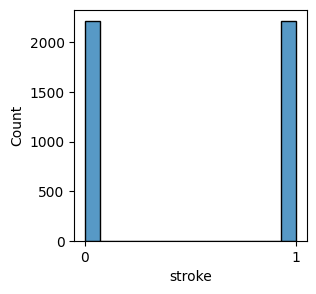

In [195]:
plt.figure(figsize=(3,3))
plt.xticks(ticks=np.arange(0,2,1))
sns.histplot(y_ros)
plt.show()

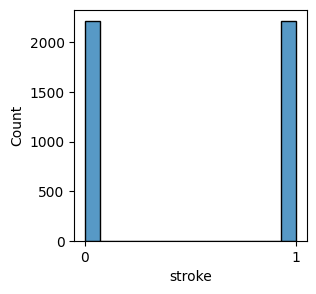

In [196]:
plt.figure(figsize=(3,3))
plt.xticks(ticks=np.arange(0,2,1))
sns.histplot(y_smote)
plt.show()

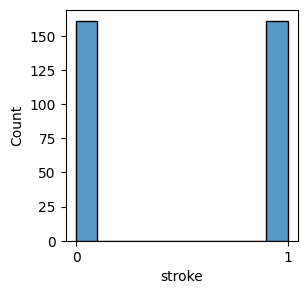

In [229]:
plt.figure(figsize=(3,3))
plt.xticks(ticks=np.arange(0,2,1))
sns.histplot(y_rus)
plt.show()

## Modelling

In [16]:
model_results = {"Model":[],"Accuracy":[],"F1":[]}

### Base model

#### LogisticRegressionCV: df_healthcare_with_dummies

In [307]:
# Define predictor and target variables
list_pred_col = df_healthcare_with_dummies.columns.tolist()
list_pred_col.remove("stroke") # excluding target variable
list_pred_col.remove("id") # excluding as it has no effect with stroke
list_pred_col.remove("ever_married_Yes") # excluding as it has no effect with stroke
# trying rest of the features
X = df_healthcare_with_dummies[list_pred_col]
y = df_healthcare_with_dummies["stroke"]

# Define train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33,random_state=23)

# Define model
LogRegCV = LogisticRegressionCV(Cs=[1, 10, 100],cv=10,solver="newton-cholesky")

# Fit model and predict y_pred
LogRegCV.fit(X_train,y_train)
y_pred_train = LogRegCV.predict(X_train)
y_pred_test = LogRegCV.predict(X_test)

# Print scores and MSE
print("Logistic regression CV accuracy (train):",accuracy_score(y_true=y_train,y_pred=y_pred_train))
print("Logistic regression CV accuracy (test):",accuracy_score(y_true=y_test,y_pred=y_pred_test))
print("Logistic regression CV f1_score (train):",f1_score(y_true=y_train,y_pred=y_pred_train))
print("Logistic regression CV f1_score (test):",f1_score(y_true=y_test,y_pred=y_pred_test))

Logistic regression CV accuracy (train): 0.9529652351738241
Logistic regression CV accuracy (test): 0.947836395969176
Logistic regression CV f1_score (train): 0.012269938650306747
Logistic regression CV f1_score (test): 0.0


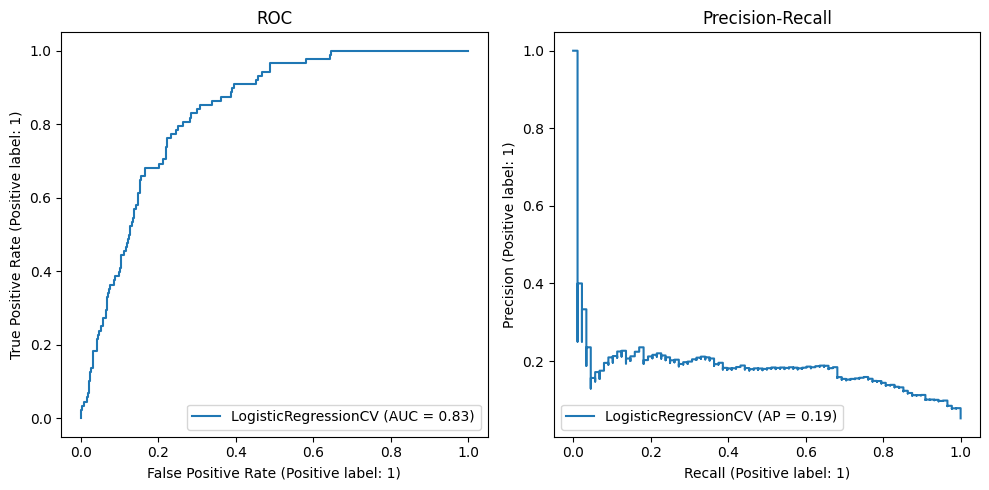

In [308]:
fig, axs = plt.subplots(1,2,figsize=(10,5))
RocCurveDisplay.from_estimator(LogRegCV,X=X_test,y=y_test,ax=axs[0])
axs[0].set_title("ROC")
PrecisionRecallDisplay.from_estimator(LogRegCV,X=X_test,y=y_test,ax=axs[1])
axs[1].set_title("Precision-Recall")
plt.tight_layout()
plt.show()

In [147]:
# Set up 5-fold cross validation  
k_fold = KFold(10, shuffle=True)
train_scores = []
train_f1 = []
test_scores = []
test_f1 = []

for k, (train, test) in enumerate(k_fold.split(X)):
    # Get training and test sets for X and y
    X_train, X_test, y_train, y_test = X.loc[train], X.loc[test], y.loc[train], y.loc[test]
    # Fit model with training set
    LogRegCV = LogisticRegressionCV(Cs=[1, 10, 100],cv=10,solver="newton-cholesky")
    LogRegCV.fit(X_train,y_train)
    # Make predictions with training and test set
    y_pred_train = LogRegCV.predict(X_train)
    y_pred_test = LogRegCV.predict(X_test)
    # Score R2 and RMSE on training and test sets and store in list
    train_scores.append(accuracy_score(y_true=y_train,y_pred=y_pred_train))
    train_f1.append(f1_score(y_true=y_train,y_pred=y_pred_train))
    test_scores.append(accuracy_score(y_true=y_test,y_pred=y_pred_test))
    test_f1.append(f1_score(y_true=y_test,y_pred=y_pred_test))
# Create a metrics_df dataframe to display r2 and rmse scores
dict_metrics = {'train_scores':train_scores,'train_f1':train_f1,'test_scores':test_scores,'test_f1':test_f1}
metrics_df = pd.DataFrame(dict_metrics)
metrics_df

train_scores  train_f1  test_scores   test_f1
0      0.951076  0.008811     0.954990  0.000000
1      0.951294  0.008850     0.953033  0.000000
2      0.950859  0.008772     0.956947  0.000000
3      0.951076  0.008811     0.954990  0.000000
4      0.952816  0.018100     0.941292  0.000000
5      0.951946  0.008969     0.947162  0.000000
6      0.951511  0.008889     0.951076  0.000000
7      0.950641  0.008734     0.958904  0.000000
8      0.950859  0.000000     0.956947  0.083333
9      0.952816  0.009132     0.939335  0.000000

In [99]:
confusion_matrix(y_true=y_train,y_pred=y_pred_train)

array([[3261,    1],
       [ 160,    1]], dtype=int64)

In [100]:
print(classification_report(y_true=y_train,y_pred=y_pred_train,zero_division=np.nan))

              precision    recall  f1-score   support

           0       0.95      1.00      0.98      3262
           1       0.50      0.01      0.01       161

    accuracy                           0.95      3423
   macro avg       0.73      0.50      0.49      3423
weighted avg       0.93      0.95      0.93      3423



In [101]:
confusion_matrix(y_true=y_test,y_pred=y_pred_test)

array([[1599,    0],
       [  88,    0]], dtype=int64)

In [102]:
print(np.asarray([['TN', 'FP'], ['FN', 'TP']]))

[['TN' 'FP']
 ['FN' 'TP']]


In [103]:
print(classification_report(y_true=y_test,y_pred=y_pred_test,zero_division=np.nan))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1599
           1        nan      0.00       nan        88

    accuracy                           0.95      1687
   macro avg       0.95      0.50      0.97      1687
weighted avg       0.95      0.95      0.97      1687



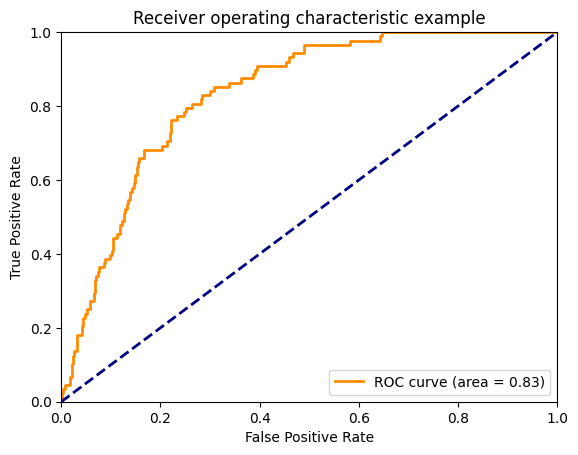

In [104]:
# Generate the prediction values for each of the test observations using predict_proba() function rather than just predict
preds = LogRegCV.predict_proba(X_test)[:,1]

# Store the false positive rate(fpr), true positive rate (tpr) in vectors for use in the graph
fpr, tpr, _ = roc_curve(y_test, preds)

# Store the Area Under the Curve (AUC) so we can annotate our graph with this metric
roc_auc = auc(fpr, tpr)

# Plot the ROC Curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw = lw, label = 'ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color = 'navy', lw = lw, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc = "lower right")
plt.show()

In [135]:
ft = SelectKBest(chi2, k=8).fit(X_train,y_train)

# Transform X
X_train_2 = ft.transform(X_train)
X_test_2 = ft.transform(X_test)

# Define model
LogRegCV = LogisticRegressionCV(Cs=[1, 10, 100],cv=10,solver="newton-cholesky")

# Fit model and predict y_pred
LogRegCV.fit(X_train_2,y_train)
y_pred_train = LogRegCV.predict(X_train_2)
y_pred_test = LogRegCV.predict(X_test_2)

# Print scores and MSE
print("Logistic regression CV accuracy (train):",accuracy_score(y_true=y_train,y_pred=y_pred_train))
print("Logistic regression CV accuracy (test):",accuracy_score(y_true=y_test,y_pred=y_pred_test))
print("Logistic regression CV f1_score (train):",f1_score(y_true=y_train,y_pred=y_pred_train))
print("Logistic regression CV f1_score (test):",f1_score(y_true=y_test,y_pred=y_pred_test))

Logistic regression CV accuracy (train): 0.9535495179666958
Logistic regression CV accuracy (test): 0.947836395969176
Logistic regression CV f1_score (train): 0.024539877300613494
Logistic regression CV f1_score (test): 0.0


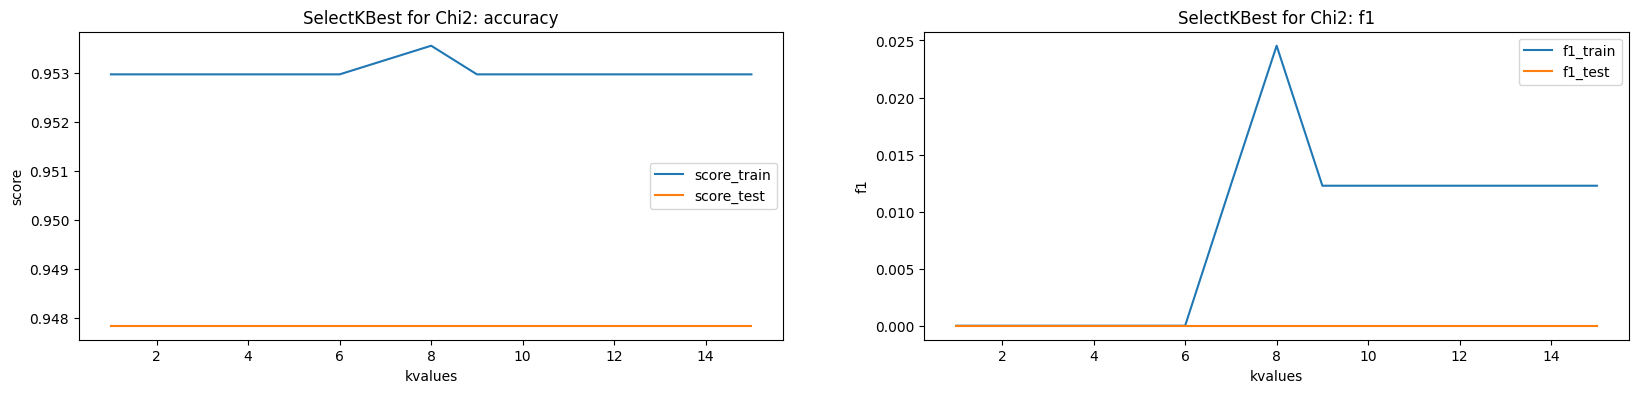

In [133]:
score_train = []
score_test = []
f1_train = []
f1_test = []
kvalues = []

for i in range(1,len(X_train.columns)+1):
    # Feature selection
    # Select top k features with chi2
    k=i
    kvalues.append(k)
    ft = SelectKBest(chi2, k=k).fit(X_train,y_train)

    # Transform X
    X_train_2 = ft.transform(X_train)
    X_test_2 = ft.transform(X_test)

    # Define model
    LogRegCV = LogisticRegressionCV(Cs=[1, 10, 100],cv=10,solver="newton-cholesky")

    # Fit model and predict y_pred
    LogRegCV.fit(X_train_2,y_train)
    y_pred_train = LogRegCV.predict(X_train_2)
    y_pred_test = LogRegCV.predict(X_test_2)

    score_train.append(accuracy_score(y_true=y_train,y_pred=y_pred_train))
    score_test.append(accuracy_score(y_true=y_test,y_pred=y_pred_test))
    f1_train.append(f1_score(y_true=y_train,y_pred=y_pred_train))
    f1_test.append(f1_score(y_true=y_test,y_pred=y_pred_test))

plt.figure(figsize=(20,4))
r,c = 1,2
plt.subplot(r,c,1)
plt.plot(kvalues,score_train,label="score_train")
plt.plot(kvalues,score_test,label="score_test")
plt.xlabel("kvalues")
plt.ylabel("score")
plt.title("SelectKBest for Chi2: accuracy")
plt.legend()
plt.subplot(r,c,2)
plt.plot(kvalues,f1_train,label="f1_train")
plt.plot(kvalues,f1_test,label="f1_test")
plt.xlabel("kvalues")
plt.ylabel("f1")
plt.title("SelectKBest for Chi2: f1")
plt.legend()
plt.show()

In [211]:
# RandomOverSampler
# Define train and test datasets
# X_train, X_test, y_train, y_test = train_test_split(X_ros,y_ros,test_size=0.33,random_state=23)

# Define model
LogRegCV = LogisticRegressionCV(Cs=[1, 10, 100],cv=10,solver="newton-cholesky")

# Fit model and predict y_pred
# LogRegCV.fit(X_train,y_train)
# y_pred_train = LogRegCV.predict(X_train)
# y_pred_test = LogRegCV.predict(X_test)

LogRegCV.fit(X_ros,y_ros)
y_pred_train = LogRegCV.predict(X_ros)
y_pred_test = LogRegCV.predict(X_test)

# Print scores and MSE
# print("Logistic regression CV accuracy (train):",accuracy_score(y_true=y_train,y_pred=y_pred_train))
# print("Logistic regression CV accuracy (test):",accuracy_score(y_true=y_test,y_pred=y_pred_test))
# print("Logistic regression CV f1_score (train):",f1_score(y_true=y_train,y_pred=y_pred_train))
# print("Logistic regression CV f1_score (test):",f1_score(y_true=y_test,y_pred=y_pred_test))

print("Logistic regression CV accuracy (train):",accuracy_score(y_true=y_ros,y_pred=y_pred_train))
print("Logistic regression CV accuracy (test):",accuracy_score(y_true=y_test,y_pred=y_pred_test))
print("Logistic regression CV f1_score (train):",f1_score(y_true=y_ros,y_pred=y_pred_train))
print("Logistic regression CV f1_score (test):",f1_score(y_true=y_test,y_pred=y_pred_test))

Logistic regression CV accuracy (train): 0.769773145309626
Logistic regression CV accuracy (test): 0.7237700059276823
Logistic regression CV f1_score (train): 0.7744744744744745
Logistic regression CV f1_score (test): 0.2360655737704918


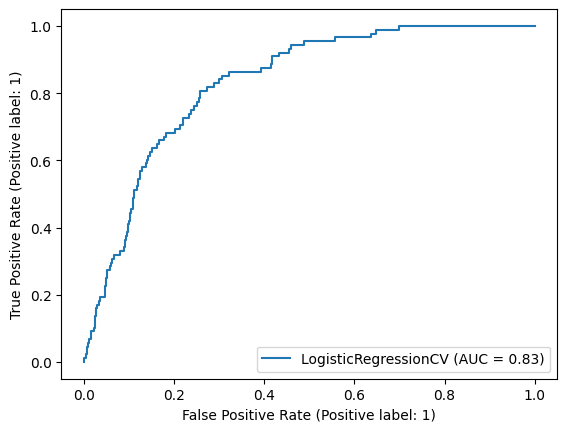

In [212]:
RocCurveDisplay.from_estimator(LogRegCV,X=X_test,y=y_test)
plt.show()

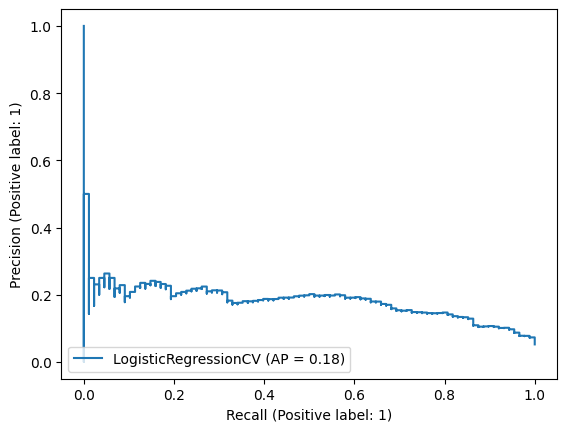

In [213]:
PrecisionRecallDisplay.from_estimator(LogRegCV,X=X_test,y=y_test)
plt.show()

In [214]:
# SMOTE - Synthetic Minority Oversampling Technique
# Define train and test datasets
# X_train, X_test, y_train, y_test = train_test_split(X_smote,y_smote,test_size=0.33,random_state=23)

# Define model
LogRegCV = LogisticRegressionCV(Cs=[1, 10, 100],cv=10,solver="newton-cholesky")

# Fit model and predict y_pred
# LogRegCV.fit(X_train,y_train)
# y_pred_train = LogRegCV.predict(X_train)
# y_pred_test = LogRegCV.predict(X_test)

LogRegCV.fit(X_smote,y_smote)
y_pred_train = LogRegCV.predict(X_smote)
y_pred_test = LogRegCV.predict(X_test)

# Print scores and MSE
# print("Logistic regression CV accuracy (train):",accuracy_score(y_true=y_train,y_pred=y_pred_train))
# print("Logistic regression CV accuracy (test):",accuracy_score(y_true=y_test,y_pred=y_pred_test))
# print("Logistic regression CV f1_score (train):",f1_score(y_true=y_train,y_pred=y_pred_train))
# print("Logistic regression CV f1_score (test):",f1_score(y_true=y_test,y_pred=y_pred_test))

print("Logistic regression CV accuracy (train):",accuracy_score(y_true=y_smote,y_pred=y_pred_train))
print("Logistic regression CV accuracy (test):",accuracy_score(y_true=y_test,y_pred=y_pred_test))
print("Logistic regression CV f1_score (train):",f1_score(y_true=y_smote,y_pred=y_pred_train))
print("Logistic regression CV f1_score (test):",f1_score(y_true=y_test,y_pred=y_pred_test))

Logistic regression CV accuracy (train): 0.8664929491109749
Logistic regression CV accuracy (test): 0.8280972139893301
Logistic regression CV f1_score (train): 0.8678099863408713
Logistic regression CV f1_score (test): 0.20765027322404375


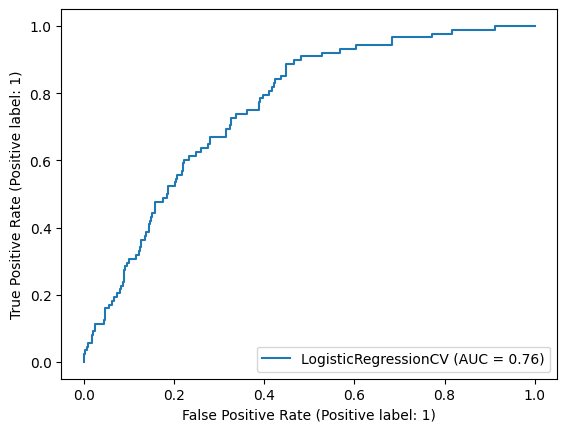

In [215]:
RocCurveDisplay.from_estimator(LogRegCV,X=X_test,y=y_test)
plt.show()

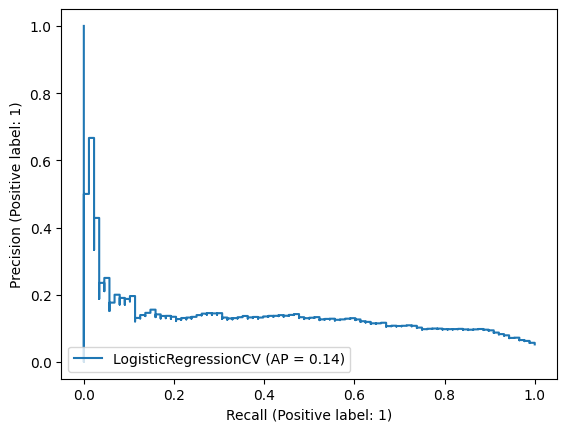

In [216]:
PrecisionRecallDisplay.from_estimator(LogRegCV,X=X_test,y=y_test)
plt.show()

In [291]:
# RUS
# Define train and test datasets
# X_train, X_test, y_train, y_test = train_test_split(X_smote,y_smote,test_size=0.33,random_state=23)

# Define model
LogRegCV = LogisticRegressionCV(Cs=[1, 10, 100],cv=10,solver="newton-cholesky")

# Fit model and predict y_pred
# LogRegCV.fit(X_train,y_train)
# y_pred_train = LogRegCV.predict(X_train)
# y_pred_test = LogRegCV.predict(X_test)

LogRegCV.fit(X_rus,y_rus)
y_pred_train = LogRegCV.predict(X_rus)
y_pred_test = LogRegCV.predict(X_test)

# Print scores and MSE
# print("Logistic regression CV accuracy (train):",accuracy_score(y_true=y_train,y_pred=y_pred_train))
# print("Logistic regression CV accuracy (test):",accuracy_score(y_true=y_test,y_pred=y_pred_test))
# print("Logistic regression CV f1_score (train):",f1_score(y_true=y_train,y_pred=y_pred_train))
# print("Logistic regression CV f1_score (test):",f1_score(y_true=y_test,y_pred=y_pred_test))

print("Logistic regression CV accuracy (train):",accuracy_score(y_true=y_rus,y_pred=y_pred_train))
print("Logistic regression CV accuracy (test):",accuracy_score(y_true=y_test,y_pred=y_pred_test))
print("Logistic regression CV f1_score (train):",f1_score(y_true=y_rus,y_pred=y_pred_train))
print("Logistic regression CV f1_score (test):",f1_score(y_true=y_test,y_pred=y_pred_test))

Logistic regression CV accuracy (train): 0.7888198757763976
Logistic regression CV accuracy (test): 0.7190278601066983
Logistic regression CV f1_score (train): 0.7964071856287425
Logistic regression CV f1_score (test): 0.23300970873786409


In [261]:
confusion_matrix(y_true=y_test,y_pred=y_pred_test)

array([[1141,  458],
       [  16,   72]], dtype=int64)

In [262]:
print(classification_report(y_true=y_test,y_pred=y_pred_test))

              precision    recall  f1-score   support

           0       0.99      0.71      0.83      1599
           1       0.14      0.82      0.23        88

    accuracy                           0.72      1687
   macro avg       0.56      0.77      0.53      1687
weighted avg       0.94      0.72      0.80      1687



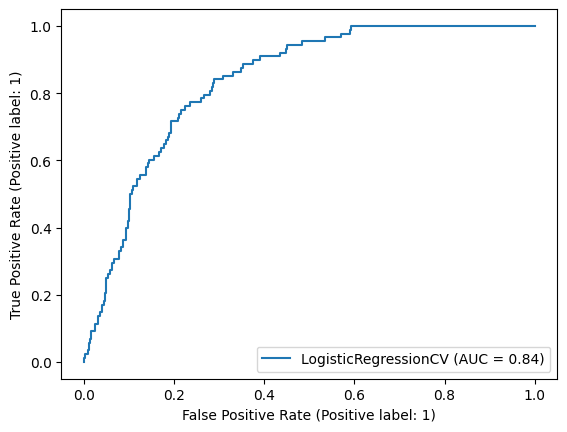

In [263]:
RocCurveDisplay.from_estimator(LogRegCV,X=X_test,y=y_test)
plt.show()

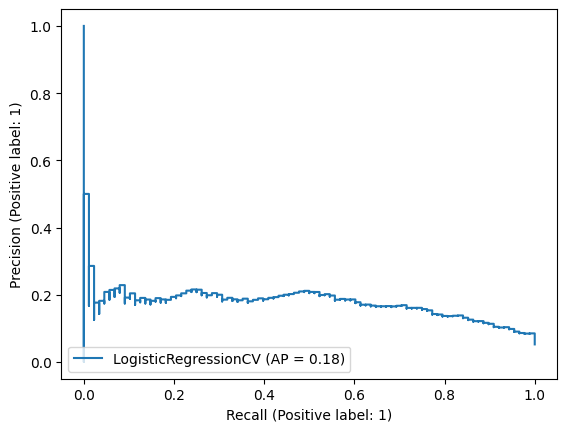

In [264]:
PrecisionRecallDisplay.from_estimator(LogRegCV,X=X_test,y=y_test)
plt.show()

In [285]:
# RUS
# Define train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X_rus2,y_rus2,test_size=0.33,random_state=23)

# Define model
LogRegCV2 = LogisticRegressionCV(Cs=[1, 10, 100],cv=10,solver="newton-cholesky")

# Fit model and predict y_pred
# LogRegCV.fit(X_train,y_train)
# y_pred_train = LogRegCV.predict(X_train)
# y_pred_test = LogRegCV.predict(X_test)

LogRegCV2.fit(X_train,y_train)
y_pred_train = LogRegCV2.predict(X_train)
y_pred_test = LogRegCV2.predict(X_test)

# Print scores and MSE
# print("Logistic regression CV accuracy (train):",accuracy_score(y_true=y_train,y_pred=y_pred_train))
# print("Logistic regression CV accuracy (test):",accuracy_score(y_true=y_test,y_pred=y_pred_test))
# print("Logistic regression CV f1_score (train):",f1_score(y_true=y_train,y_pred=y_pred_train))
# print("Logistic regression CV f1_score (test):",f1_score(y_true=y_test,y_pred=y_pred_test))

print("Logistic regression CV accuracy (train):",accuracy_score(y_true=y_train,y_pred=y_pred_train))
print("Logistic regression CV accuracy (test):",accuracy_score(y_true=y_test,y_pred=y_pred_test))
print("Logistic regression CV f1_score (train):",f1_score(y_true=y_train,y_pred=y_pred_train))
print("Logistic regression CV f1_score (test):",f1_score(y_true=y_test,y_pred=y_pred_test))

Logistic regression CV accuracy (train): 0.7717717717717718
Logistic regression CV accuracy (test): 0.7393939393939394
Logistic regression CV f1_score (train): 0.7840909090909092
Logistic regression CV f1_score (test): 0.7425149700598802


#### LogisticRegression: df_healthcare_with_dummies

In [ ]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

sfs = SFS(LogRegCV,
         k_features='best',
         forward=True,
         floating=False, 
         scoring='accuracy',
         cv=10)

sfs = sfs.fit(X_train,y_train)

pd.DataFrame.from_dict(sfs.get_metric_dict(confidence_interval=0.95)).T

In [ ]:
plot_sfs(sfs.get_metric_dict(), kind='std_err')
plt.grid()
plt.show()

In [125]:
# Define predictor and target variables
list_pred_col = df_healthcare_with_dummies.columns.tolist()
list_pred_col.remove("stroke") # excluding target variable
list_pred_col.remove("id") # excluding as it has no effect with stroke
list_pred_col.remove("ever_married_Yes") # excluding as it has no effect with stroke
# trying rest of the features
X = df_healthcare_with_dummies[list_pred_col]
y = df_healthcare_with_dummies["stroke"]

# Define train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33,random_state=23)

# Define model
LogReg = LogisticRegression(max_iter=1000)

# Fit model and predict y_pred
LogReg.fit(X_train,y_train)
y_pred_train = LogReg.predict(X_train)
y_pred_test = LogReg.predict(X_test)

# Print scores and MSE
print("Logistic regression accuracy (train):",accuracy_score(y_true=y_train,y_pred=y_pred_train))
print("Logistic regression accuracy (test):",accuracy_score(y_true=y_test,y_pred=y_pred_test))
print("Logistic regression f1_score (train):",f1_score(y_true=y_train,y_pred=y_pred_train))
print("Logistic regression f1_score (test):",f1_score(y_true=y_test,y_pred=y_pred_test))

Logistic regression accuracy (train): 0.9529652351738241
Logistic regression accuracy (test): 0.947836395969176
Logistic regression f1_score (train): 0.012269938650306747
Logistic regression f1_score (test): 0.0


In [121]:
confusion_matrix(y_true=y_train,y_pred=y_pred_train)

array([[3261,    1],
       [ 160,    1]], dtype=int64)

In [122]:
confusion_matrix(y_true=y_test,y_pred=y_pred_test)

array([[1599,    0],
       [  88,    0]], dtype=int64)

In [123]:
print(classification_report(y_true=y_test,y_pred=y_pred_test))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1599
           1       0.00      0.00      0.00        88

    accuracy                           0.95      1687
   macro avg       0.47      0.50      0.49      1687
weighted avg       0.90      0.95      0.92      1687



C:\Users\Admin\anaconda3\envs\IOD_mini_project2\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Admin\anaconda3\envs\IOD_mini_project2\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Admin\anaconda3\envs\IOD_mini_project2\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

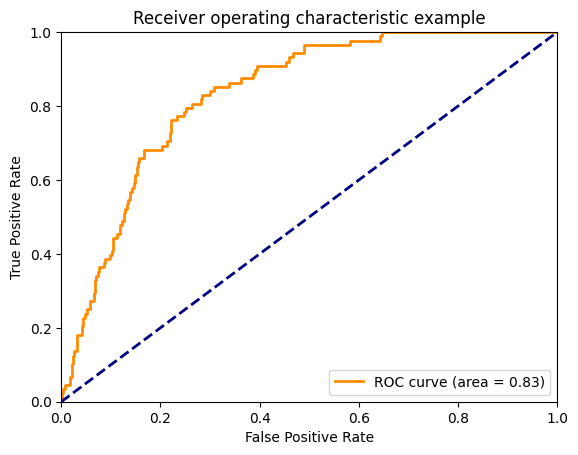

In [124]:
# Generate the prediction values for each of the test observations using predict_proba() function rather than just predict
preds = LogReg.predict_proba(X_test)[:,1]

# Store the false positive rate(fpr), true positive rate (tpr) in vectors for use in the graph
fpr, tpr, _ = roc_curve(y_test, preds)

# Store the Area Under the Curve (AUC) so we can annotate our graph with this metric
roc_auc = auc(fpr, tpr)

# Plot the ROC Curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw = lw, label = 'ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color = 'navy', lw = lw, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc = "lower right")
plt.show()

In [127]:
lr_params = {
    'penalty': ['l1','l2'],
    'C': [1, 10, 100]
}
gs = GridSearchCV(estimator=LogisticRegression(max_iter=1000,solver='liblinear'),param_grid=lr_params,verbose=1,n_jobs=-1) # ‘liblinear’ supports [‘l1’, ‘l2’] penalties
gs_result = gs.fit(X_test,y_test)
print(gs_result.best_score_)
print(gs_result.best_params_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
0.9472442189173529
{'C': 1, 'penalty': 'l1'}


#### RidgeClassifierCV: df_healthcare_with_dummies

In [137]:
# Define predictor and target variables
list_pred_col = df_healthcare_with_dummies.columns.tolist()
list_pred_col.remove("stroke") # excluding target variable
list_pred_col.remove("id") # excluding as it has no effect with stroke
list_pred_col.remove("ever_married_Yes") # excluding as it has no effect with stroke
# trying rest of the features
X = df_healthcare_with_dummies[list_pred_col]
y = df_healthcare_with_dummies["stroke"]

# Define train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33,random_state=23)

# Define model
RidgeClassCV = RidgeClassifierCV()

# Fit model and predict y_pred
RidgeClassCV.fit(X_train,y_train)
y_pred_train = RidgeClassCV.predict(X_train)
y_pred_test = RidgeClassCV.predict(X_test)

# Print scores and MSE
print("Logistic regression CV accuracy (train):",accuracy_score(y_true=y_train,y_pred=y_pred_train))
print("Logistic regression CV accuracy (test):",accuracy_score(y_true=y_test,y_pred=y_pred_test))
print("Logistic regression CV f1_score (train):",f1_score(y_true=y_train,y_pred=y_pred_train))
print("Logistic regression CV f1_score (test):",f1_score(y_true=y_test,y_pred=y_pred_test))

Logistic regression CV accuracy (train): 0.9529652351738241
Logistic regression CV accuracy (test): 0.947836395969176
Logistic regression CV f1_score (train): 0.0
Logistic regression CV f1_score (test): 0.0


In [138]:
confusion_matrix(y_true=y_train,y_pred=y_pred_train)

array([[3262,    0],
       [ 161,    0]], dtype=int64)

In [139]:
confusion_matrix(y_true=y_test,y_pred=y_pred_test)

array([[1599,    0],
       [  88,    0]], dtype=int64)

In [140]:
print(classification_report(y_true=y_test,y_pred=y_pred_test,zero_division=np.nan))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1599
           1        nan      0.00       nan        88

    accuracy                           0.95      1687
   macro avg       0.95      0.50      0.97      1687
weighted avg       0.95      0.95      0.97      1687



In [217]:
# SMOTE - Synthetic Minority Oversampling Technique
# Define train and test datasets
# X_train, X_test, y_train, y_test = train_test_split(X_smote,y_smote,test_size=0.33,random_state=23)

# Define model
RidgeClassCV = RidgeClassifierCV()

# Fit model and predict y_pred
# LogRegCV.fit(X_train,y_train)
# y_pred_train = LogRegCV.predict(X_train)
# y_pred_test = LogRegCV.predict(X_test)

RidgeClassCV.fit(X_smote,y_smote)
y_pred_train = RidgeClassCV.predict(X_smote)
y_pred_test = RidgeClassCV.predict(X_test)

# Print scores and MSE
# print("Logistic regression CV accuracy (train):",accuracy_score(y_true=y_train,y_pred=y_pred_train))
# print("Logistic regression CV accuracy (test):",accuracy_score(y_true=y_test,y_pred=y_pred_test))
# print("Logistic regression CV f1_score (train):",f1_score(y_true=y_train,y_pred=y_pred_train))
# print("Logistic regression CV f1_score (test):",f1_score(y_true=y_test,y_pred=y_pred_test))

print("Logistic regression CV accuracy (train):",accuracy_score(y_true=y_smote,y_pred=y_pred_train))
print("Logistic regression CV accuracy (test):",accuracy_score(y_true=y_test,y_pred=y_pred_test))
print("Logistic regression CV f1_score (train):",f1_score(y_true=y_smote,y_pred=y_pred_train))
print("Logistic regression CV f1_score (test):",f1_score(y_true=y_test,y_pred=y_pred_test))

Logistic regression CV accuracy (train): 0.8674126302881667
Logistic regression CV accuracy (test): 0.8269116775340841
Logistic regression CV f1_score (train): 0.8689989398758139
Logistic regression CV f1_score (test): 0.20652173913043476


#### Perceptron: df_healthcare_with_dummies

In [143]:
# Define predictor and target variables
list_pred_col = df_healthcare_with_dummies.columns.tolist()
list_pred_col.remove("stroke") # excluding target variable
list_pred_col.remove("id") # excluding as it has no effect with stroke
list_pred_col.remove("ever_married_Yes") # excluding as it has no effect with stroke
# trying rest of the features
X = df_healthcare_with_dummies[list_pred_col]
y = df_healthcare_with_dummies["stroke"]

# Define train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33,random_state=23)

# Define model
perc = Perceptron()

# Fit model and predict y_pred
perc.fit(X_train,y_train)
y_pred_train = perc.predict(X_train)
y_pred_test = perc.predict(X_test)

# Print scores and MSE
print("Logistic regression CV accuracy (train):",accuracy_score(y_true=y_train,y_pred=y_pred_train))
print("Logistic regression CV accuracy (test):",accuracy_score(y_true=y_test,y_pred=y_pred_test))
print("Logistic regression CV f1_score (train):",f1_score(y_true=y_train,y_pred=y_pred_train))
print("Logistic regression CV f1_score (test):",f1_score(y_true=y_test,y_pred=y_pred_test))

Logistic regression CV accuracy (train): 0.9529652351738241
Logistic regression CV accuracy (test): 0.947836395969176
Logistic regression CV f1_score (train): 0.0
Logistic regression CV f1_score (test): 0.0


#### LinearSVC: df_healthcare_with_dummies

In [148]:
# Define predictor and target variables
list_pred_col = df_healthcare_with_dummies.columns.tolist()
list_pred_col.remove("stroke") # excluding target variable
list_pred_col.remove("id") # excluding as it has no effect with stroke
list_pred_col.remove("ever_married_Yes") # excluding as it has no effect with stroke
# trying rest of the features
X = df_healthcare_with_dummies[list_pred_col]
y = df_healthcare_with_dummies["stroke"]

# Define train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33,random_state=23)

# Define model
linSVC = LinearSVC()

# Fit model and predict y_pred
linSVC.fit(X_train,y_train)
y_pred_train = linSVC.predict(X_train)
y_pred_test = linSVC.predict(X_test)

# Print scores and MSE
print("Logistic regression CV accuracy (train):",accuracy_score(y_true=y_train,y_pred=y_pred_train))
print("Logistic regression CV accuracy (test):",accuracy_score(y_true=y_test,y_pred=y_pred_test))
print("Logistic regression CV f1_score (train):",f1_score(y_true=y_train,y_pred=y_pred_train))
print("Logistic regression CV f1_score (test):",f1_score(y_true=y_test,y_pred=y_pred_test))

Logistic regression CV accuracy (train): 0.9529652351738241
Logistic regression CV accuracy (test): 0.947836395969176
Logistic regression CV f1_score (train): 0.0
Logistic regression CV f1_score (test): 0.0


C:\Users\Admin\anaconda3\envs\IOD_mini_project2\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\Admin\anaconda3\envs\IOD_mini_project2\lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


#### SVC: df_healthcare_with_dummies

In [149]:
# Define predictor and target variables
list_pred_col = df_healthcare_with_dummies.columns.tolist()
list_pred_col.remove("stroke") # excluding target variable
list_pred_col.remove("id") # excluding as it has no effect with stroke
list_pred_col.remove("ever_married_Yes") # excluding as it has no effect with stroke
# trying rest of the features
X = df_healthcare_with_dummies[list_pred_col]
y = df_healthcare_with_dummies["stroke"]

# Define train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33,random_state=23)

# Define model
svc = SVC()

# Fit model and predict y_pred
svc.fit(X_train,y_train)
y_pred_train = svc.predict(X_train)
y_pred_test = svc.predict(X_test)

# Print scores and MSE
print("Logistic regression CV accuracy (train):",accuracy_score(y_true=y_train,y_pred=y_pred_train))
print("Logistic regression CV accuracy (test):",accuracy_score(y_true=y_test,y_pred=y_pred_test))
print("Logistic regression CV f1_score (train):",f1_score(y_true=y_train,y_pred=y_pred_train))
print("Logistic regression CV f1_score (test):",f1_score(y_true=y_test,y_pred=y_pred_test))

Logistic regression CV accuracy (train): 0.9529652351738241
Logistic regression CV accuracy (test): 0.947836395969176
Logistic regression CV f1_score (train): 0.0
Logistic regression CV f1_score (test): 0.0


In [150]:
# Set up 5-fold cross validation  
k_fold = KFold(10, shuffle=True)
train_scores = []
train_f1 = []
test_scores = []
test_f1 = []

for k, (train, test) in enumerate(k_fold.split(X)):
    # Get training and test sets for X and y
    X_train, X_test, y_train, y_test = X.loc[train], X.loc[test], y.loc[train], y.loc[test]
    # Fit model with training set
    svc = SVC()
    svc.fit(X_train,y_train)
    # Make predictions with training and test set
    y_pred_train = svc.predict(X_train)
    y_pred_test = svc.predict(X_test)
    # Score R2 and RMSE on training and test sets and store in list
    train_scores.append(accuracy_score(y_true=y_train,y_pred=y_pred_train))
    train_f1.append(f1_score(y_true=y_train,y_pred=y_pred_train))
    test_scores.append(accuracy_score(y_true=y_test,y_pred=y_pred_test))
    test_f1.append(f1_score(y_true=y_test,y_pred=y_pred_test))
# Create a metrics_df dataframe to display r2 and rmse scores
dict_metrics = {'train_scores':train_scores,'train_f1':train_f1,'test_scores':test_scores,'test_f1':test_f1}
metrics_df = pd.DataFrame(dict_metrics)
metrics_df

train_scores  train_f1  test_scores  test_f1
0      0.950641       0.0     0.956947      0.0
1      0.952381       0.0     0.941292      0.0
2      0.949989       0.0     0.962818      0.0
3      0.952598       0.0     0.939335      0.0
4      0.951729       0.0     0.947162      0.0
5      0.951946       0.0     0.945205      0.0
6      0.950641       0.0     0.956947      0.0
7      0.949989       0.0     0.962818      0.0
8      0.951511       0.0     0.949119      0.0
9      0.951294       0.0     0.951076      0.0

In [219]:
# SMOTE - Synthetic Minority Oversampling Technique
# Define train and test datasets
# X_train, X_test, y_train, y_test = train_test_split(X_smote,y_smote,test_size=0.33,random_state=23)

# Define model
svc = SVC()

# Fit model and predict y_pred
# LogRegCV.fit(X_train,y_train)
# y_pred_train = LogRegCV.predict(X_train)
# y_pred_test = LogRegCV.predict(X_test)

svc.fit(X_smote,y_smote)
y_pred_train = svc.predict(X_smote)
y_pred_test = svc.predict(X_test)

# Print scores and MSE
# print("Logistic regression CV accuracy (train):",accuracy_score(y_true=y_train,y_pred=y_pred_train))
# print("Logistic regression CV accuracy (test):",accuracy_score(y_true=y_test,y_pred=y_pred_test))
# print("Logistic regression CV f1_score (train):",f1_score(y_true=y_train,y_pred=y_pred_train))
# print("Logistic regression CV f1_score (test):",f1_score(y_true=y_test,y_pred=y_pred_test))

print("Logistic regression CV accuracy (train):",accuracy_score(y_true=y_smote,y_pred=y_pred_train))
print("Logistic regression CV accuracy (test):",accuracy_score(y_true=y_test,y_pred=y_pred_test))
print("Logistic regression CV f1_score (train):",f1_score(y_true=y_smote,y_pred=y_pred_train))
print("Logistic regression CV f1_score (test):",f1_score(y_true=y_test,y_pred=y_pred_test))

Logistic regression CV accuracy (train): 0.7725321888412017
Logistic regression CV accuracy (test): 0.6870183758150563
Logistic regression CV f1_score (train): 0.7871485943775101
Logistic regression CV f1_score (test): 0.21661721068249257


#### NuSVC: df_healthcare_with_dummies

In [151]:
# Define predictor and target variables
list_pred_col = df_healthcare_with_dummies.columns.tolist()
list_pred_col.remove("stroke") # excluding target variable
list_pred_col.remove("id") # excluding as it has no effect with stroke
list_pred_col.remove("ever_married_Yes") # excluding as it has no effect with stroke
# trying rest of the features
X = df_healthcare_with_dummies[list_pred_col]
y = df_healthcare_with_dummies["stroke"]

# Define train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33,random_state=23)

# Define model
nu_svc = NuSVC()

# Fit model and predict y_pred
nu_svc.fit(X_train,y_train)
y_pred_train = nu_svc.predict(X_train)
y_pred_test = nu_svc.predict(X_test)

# Print scores and MSE
print("Logistic regression CV accuracy (train):",accuracy_score(y_true=y_train,y_pred=y_pred_train))
print("Logistic regression CV accuracy (test):",accuracy_score(y_true=y_test,y_pred=y_pred_test))
print("Logistic regression CV f1_score (train):",f1_score(y_true=y_train,y_pred=y_pred_train))
print("Logistic regression CV f1_score (test):",f1_score(y_true=y_test,y_pred=y_pred_test))

ValueError: specified nu is infeasible

#### MultinomialNB: df_healthcare_with_dummies

In [244]:
# Define predictor and target variables
list_pred_col = df_healthcare_with_dummies.columns.tolist()
list_pred_col.remove("stroke") # excluding target variable
list_pred_col.remove("id") # excluding as it has no effect with stroke
list_pred_col.remove("ever_married_Yes") # excluding as it has no effect with stroke
# trying rest of the features
X = df_healthcare_with_dummies[list_pred_col]
y = df_healthcare_with_dummies["stroke"]

# Define train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33,random_state=23)

# Define model
mnb = MultinomialNB(alpha=0.3511191734215131)

# Fit model and predict y_pred
mnb.fit(X_train,y_train)
y_pred_train = mnb.predict(X_train)
y_pred_test = mnb.predict(X_test)

# Print scores and MSE
print("Logistic regression CV accuracy (train):",accuracy_score(y_true=y_train,y_pred=y_pred_train))
print("Logistic regression CV accuracy (test):",accuracy_score(y_true=y_test,y_pred=y_pred_test))
print("Logistic regression CV f1_score (train):",f1_score(y_true=y_train,y_pred=y_pred_train))
print("Logistic regression CV f1_score (test):",f1_score(y_true=y_test,y_pred=y_pred_test))

Logistic regression CV accuracy (train): 0.8074788197487583
Logistic regression CV accuracy (test): 0.8091286307053942
Logistic regression CV f1_score (train): 0.18942189421894218
Logistic regression CV f1_score (test): 0.20297029702970296


In [246]:
confusion_matrix(y_true=y_train,y_pred=y_pred_train)

array([[2687,  575],
       [  84,   77]], dtype=int64)

In [247]:
confusion_matrix(y_true=y_test,y_pred=y_pred_test)

array([[1324,  275],
       [  47,   41]], dtype=int64)

In [248]:
41/(41+275)

0.12974683544303797

In [249]:
print(classification_report(y_true=y_test,y_pred=y_pred_test))

              precision    recall  f1-score   support

           0       0.97      0.83      0.89      1599
           1       0.13      0.47      0.20        88

    accuracy                           0.81      1687
   macro avg       0.55      0.65      0.55      1687
weighted avg       0.92      0.81      0.86      1687



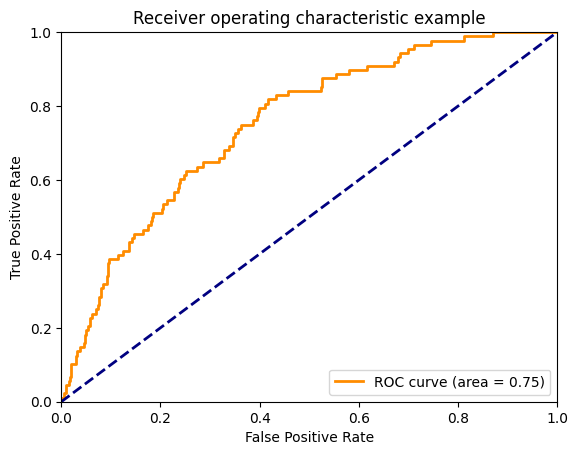

In [245]:
# Generate the prediction values for each of the test observations using predict_proba() function rather than just predict
preds = mnb.predict_proba(X_test)[:,1]

# Store the false positive rate(fpr), true positive rate (tpr) in vectors for use in the graph
fpr, tpr, _ = roc_curve(y_test, preds)

# Store the Area Under the Curve (AUC) so we can annotate our graph with this metric
roc_auc = auc(fpr, tpr)

# Plot the ROC Curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw = lw, label = 'ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color = 'navy', lw = lw, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc = "lower right")
plt.show()

In [246]:
from sklearn.model_selection import RepeatedStratifiedKFold

cv_method = RepeatedStratifiedKFold(n_splits=5, 
                                    n_repeats=3, 
                                    random_state=23)

from sklearn.preprocessing import PowerTransformer
# params_NB = {'alpha': [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]}
params_NB = {"alpha":np.logspace(0,-9, num=100)}
gs_NB = GridSearchCV(estimator=MultinomialNB(), 
                     param_grid=params_NB, 
                     cv=cv_method,
                     verbose=1, 
                     scoring='f1')

# Data_transformed = PowerTransformer().fit_transform(X_test)

gs_NB.fit(X_test, y_test);

Fitting 15 folds for each of 100 candidates, totalling 1500 fits


In [247]:
gs_NB.best_params_

{'alpha': 0.3511191734215131}

In [248]:
gs_NB.best_score_

0.22709412278313457

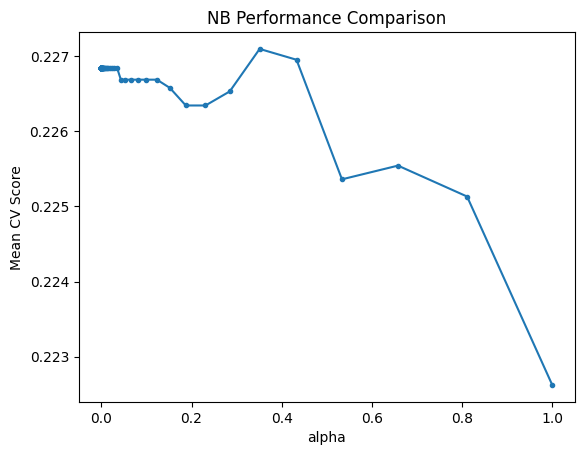

In [249]:
results_NB = pd.DataFrame(gs_NB.cv_results_['params'])
results_NB['test_score'] = gs_NB.cv_results_['mean_test_score']
plt.plot(results_NB['alpha'], results_NB['test_score'], marker = '.')    
plt.xlabel('alpha')
plt.ylabel("Mean CV Score")
plt.title("NB Performance Comparison")
plt.show()

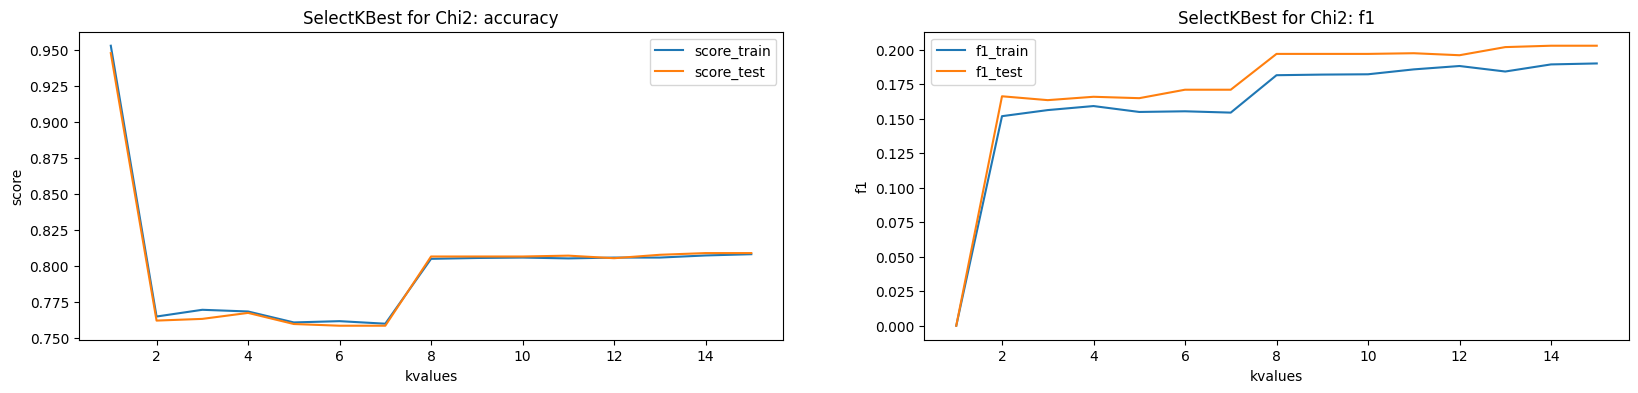

In [164]:
score_train = []
score_test = []
f1_train = []
f1_test = []
kvalues = []

for i in range(1,len(X_train.columns)+1):
    # Feature selection
    # Select top k features with chi2
    k=i
    kvalues.append(k)
    ft = SelectKBest(chi2, k=k).fit(X_train,y_train)

    # Transform X
    X_train_2 = ft.transform(X_train)
    X_test_2 = ft.transform(X_test)

    # Define model
    mnb = MultinomialNB()

    # Fit model and predict y_pred
    mnb.fit(X_train_2,y_train)
    y_pred_train = mnb.predict(X_train_2)
    y_pred_test = mnb.predict(X_test_2)

    score_train.append(accuracy_score(y_true=y_train,y_pred=y_pred_train))
    score_test.append(accuracy_score(y_true=y_test,y_pred=y_pred_test))
    f1_train.append(f1_score(y_true=y_train,y_pred=y_pred_train))
    f1_test.append(f1_score(y_true=y_test,y_pred=y_pred_test))

plt.figure(figsize=(20,4))
r,c = 1,2
plt.subplot(r,c,1)
plt.plot(kvalues,score_train,label="score_train")
plt.plot(kvalues,score_test,label="score_test")
plt.xlabel("kvalues")
plt.ylabel("score")
plt.title("SelectKBest for Chi2: accuracy")
plt.legend()
plt.subplot(r,c,2)
plt.plot(kvalues,f1_train,label="f1_train")
plt.plot(kvalues,f1_test,label="f1_test")
plt.xlabel("kvalues")
plt.ylabel("f1")
plt.title("SelectKBest for Chi2: f1")
plt.legend()
plt.show()

In [268]:
# SMOTE - Synthetic Minority Oversampling Technique
# Define train and test datasets
# X_train, X_test, y_train, y_test = train_test_split(X_smote,y_smote,test_size=0.33,random_state=23)

# Define model
mnb = MultinomialNB(alpha=0.3511191734215131)

# Fit model and predict y_pred
# LogRegCV.fit(X_train,y_train)
# y_pred_train = LogRegCV.predict(X_train)
# y_pred_test = LogRegCV.predict(X_test)

mnb.fit(X_rus,y_rus)
y_pred_train = mnb.predict(X_rus)
y_pred_test = mnb.predict(X_test)

# Print scores and MSE
# print("Logistic regression CV accuracy (train):",accuracy_score(y_true=y_train,y_pred=y_pred_train))
# print("Logistic regression CV accuracy (test):",accuracy_score(y_true=y_test,y_pred=y_pred_test))
# print("Logistic regression CV f1_score (train):",f1_score(y_true=y_train,y_pred=y_pred_train))
# print("Logistic regression CV f1_score (test):",f1_score(y_true=y_test,y_pred=y_pred_test))

print("Logistic regression CV accuracy (train):",accuracy_score(y_true=y_rus,y_pred=y_pred_train))
print("Logistic regression CV accuracy (test):",accuracy_score(y_true=y_test,y_pred=y_pred_test))
print("Logistic regression CV f1_score (train):",f1_score(y_true=y_rus,y_pred=y_pred_train))
print("Logistic regression CV f1_score (test):",f1_score(y_true=y_test,y_pred=y_pred_test))

Logistic regression CV accuracy (train): 0.6863354037267081
Logistic regression CV accuracy (test): 0.6484884410195614
Logistic regression CV f1_score (train): 0.6930091185410334
Logistic regression CV f1_score (test): 0.1659634317862166


#### GaussianNB: df_healthcare_with_dummies

In [201]:
# Define predictor and target variables
list_pred_col = df_healthcare_with_dummies.columns.tolist()
list_pred_col.remove("stroke") # excluding target variable
list_pred_col.remove("id") # excluding as it has no effect with stroke
list_pred_col.remove("ever_married_Yes") # excluding as it has no effect with stroke
# trying rest of the features
X = df_healthcare_with_dummies[list_pred_col]
y = df_healthcare_with_dummies["stroke"]

# Define train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33,random_state=23)

# Define model
gnb = GaussianNB(var_smoothing=0.003511191734215131)

# Fit model and predict y_pred
gnb.fit(X_train,y_train)
y_pred_train = gnb.predict(X_train)
y_pred_test = gnb.predict(X_test)

# Print scores and MSE
print("Logistic regression CV accuracy (train):",accuracy_score(y_true=y_train,y_pred=y_pred_train))
print("Logistic regression CV accuracy (test):",accuracy_score(y_true=y_test,y_pred=y_pred_test))
print("Logistic regression CV f1_score (train):",f1_score(y_true=y_train,y_pred=y_pred_train))
print("Logistic regression CV f1_score (test):",f1_score(y_true=y_test,y_pred=y_pred_test))

Logistic regression CV accuracy (train): 0.9269646508910313
Logistic regression CV accuracy (test): 0.9057498518079431
Logistic regression CV f1_score (train): 0.1883116883116883
Logistic regression CV f1_score (test): 0.15873015873015872


In [202]:
confusion_matrix(y_true=y_test,y_pred=y_pred_test)

array([[1513,   86],
       [  73,   15]], dtype=int64)

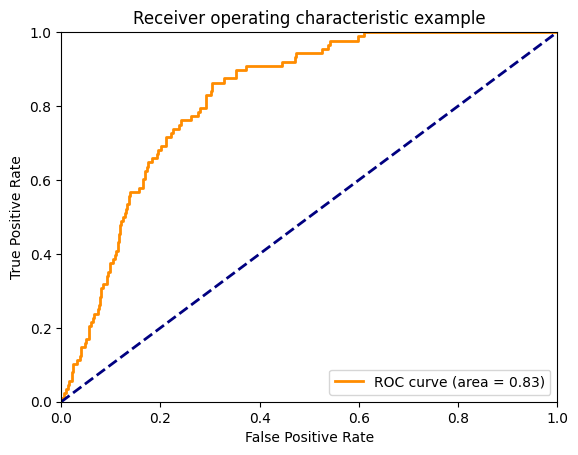

In [203]:
# Generate the prediction values for each of the test observations using predict_proba() function rather than just predict
preds = gnb.predict_proba(X_test)[:,1]

# Store the false positive rate(fpr), true positive rate (tpr) in vectors for use in the graph
fpr, tpr, _ = roc_curve(y_test, preds)

# Store the Area Under the Curve (AUC) so we can annotate our graph with this metric
roc_auc = auc(fpr, tpr)

# Plot the ROC Curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw = lw, label = 'ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color = 'navy', lw = lw, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc = "lower right")
plt.show()

In [211]:
from sklearn.model_selection import RepeatedStratifiedKFold

cv_method = RepeatedStratifiedKFold(n_splits=5, 
                                    n_repeats=3, 
                                    random_state=23)

from sklearn.preprocessing import PowerTransformer
params_NB = {'var_smoothing': np.logspace(0,-9, num=100)}

gs_NB = GridSearchCV(estimator=gnb, 
                     param_grid=params_NB, 
                     cv=cv_method,
                     verbose=1, 
                     scoring='roc_auc')

Data_transformed = PowerTransformer().fit_transform(X_test)

gs_NB.fit(Data_transformed, y_test);

Fitting 15 folds for each of 100 candidates, totalling 1500 fits


In [212]:
gs_NB.best_params_

{'var_smoothing': 0.003511191734215131}

In [213]:
gs_NB.best_score_

0.8210122267297724

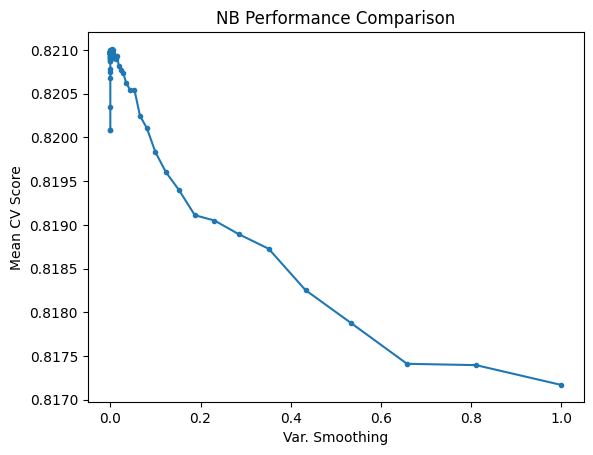

In [214]:
results_NB = pd.DataFrame(gs_NB.cv_results_['params'])
results_NB['test_score'] = gs_NB.cv_results_['mean_test_score']
plt.plot(results_NB['var_smoothing'], results_NB['test_score'], marker = '.')    
plt.xlabel('Var. Smoothing')
plt.ylabel("Mean CV Score")
plt.title("NB Performance Comparison")
plt.show()

In [221]:
# SMOTE - Synthetic Minority Oversampling Technique
# Define train and test datasets
# X_train, X_test, y_train, y_test = train_test_split(X_smote,y_smote,test_size=0.33,random_state=23)

# Define model
gnb = GaussianNB()

# Fit model and predict y_pred
# LogRegCV.fit(X_train,y_train)
# y_pred_train = LogRegCV.predict(X_train)
# y_pred_test = LogRegCV.predict(X_test)

gnb.fit(X_smote,y_smote)
y_pred_train = gnb.predict(X_smote)
y_pred_test = gnb.predict(X_test)

# Print scores and MSE
# print("Logistic regression CV accuracy (train):",accuracy_score(y_true=y_train,y_pred=y_pred_train))
# print("Logistic regression CV accuracy (test):",accuracy_score(y_true=y_test,y_pred=y_pred_test))
# print("Logistic regression CV f1_score (train):",f1_score(y_true=y_train,y_pred=y_pred_train))
# print("Logistic regression CV f1_score (test):",f1_score(y_true=y_test,y_pred=y_pred_test))

print("Logistic regression CV accuracy (train):",accuracy_score(y_true=y_smote,y_pred=y_pred_train))
print("Logistic regression CV accuracy (test):",accuracy_score(y_true=y_test,y_pred=y_pred_test))
print("Logistic regression CV f1_score (train):",f1_score(y_true=y_smote,y_pred=y_pred_train))
print("Logistic regression CV f1_score (test):",f1_score(y_true=y_test,y_pred=y_pred_test))

Logistic regression CV accuracy (train): 0.717504598405886
Logistic regression CV accuracy (test): 0.4309425014819206
Logistic regression CV f1_score (train): 0.7774960763008573
Logistic regression CV f1_score (test): 0.1443850267379679


#### BernoulliNB: df_healthcare_with_dummies

In [11]:
# Define predictor and target variables
list_pred_col = df_healthcare_with_dummies.columns.tolist()
list_pred_col.remove("stroke") # excluding target variable
list_pred_col.remove("id") # excluding as it has no effect with stroke
list_pred_col.remove("ever_married_Yes") # excluding as it has no effect with stroke
# trying rest of the features
X = df_healthcare_with_dummies[list_pred_col]
y = df_healthcare_with_dummies["stroke"]

# Define train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33,random_state=23)

# Define model
bnb = BernoulliNB()

# Fit model and predict y_pred
bnb.fit(X_train,y_train)
y_pred_train = bnb.predict(X_train)
y_pred_test = bnb.predict(X_test)

# Print scores and MSE
print("Logistic regression CV accuracy (train):",accuracy_score(y_true=y_train,y_pred=y_pred_train))
print("Logistic regression CV accuracy (test):",accuracy_score(y_true=y_test,y_pred=y_pred_test))
print("Logistic regression CV f1_score (train):",f1_score(y_true=y_train,y_pred=y_pred_train))
print("Logistic regression CV f1_score (test):",f1_score(y_true=y_test,y_pred=y_pred_test))

Logistic regression CV accuracy (train): 0.9515045281916448
Logistic regression CV accuracy (test): 0.946058091286307
Logistic regression CV f1_score (train): 0.011904761904761904
Logistic regression CV f1_score (test): 0.0


#### DecisionTreeClassifier: df_healthcare_with_dummies

In [18]:
# Define predictor and target variables
list_pred_col = df_healthcare_with_dummies.columns.tolist()
list_pred_col.remove("stroke") # excluding target variable
list_pred_col.remove("id") # excluding as it has no effect with stroke
list_pred_col.remove("ever_married_Yes") # excluding as it has no effect with stroke
# trying rest of the features
X = df_healthcare_with_dummies[list_pred_col]
y = df_healthcare_with_dummies["stroke"]

# Define train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33,random_state=23)

# Define model
dt_clf = DecisionTreeClassifier()

# Fit model and predict y_pred
dt_clf.fit(X_train,y_train)
y_pred_train = dt_clf.predict(X_train)
y_pred_test = dt_clf.predict(X_test)

# Print scores and MSE
print("Logistic regression CV accuracy (train):",accuracy_score(y_true=y_train,y_pred=y_pred_train))
print("Logistic regression CV accuracy (test):",accuracy_score(y_true=y_test,y_pred=y_pred_test))
print("Logistic regression CV f1_score (train):",f1_score(y_true=y_train,y_pred=y_pred_train))
print("Logistic regression CV f1_score (test):",f1_score(y_true=y_test,y_pred=y_pred_test))

Logistic regression CV accuracy (train): 1.0
Logistic regression CV accuracy (test): 0.9027860106698281
Logistic regression CV f1_score (train): 1.0
Logistic regression CV f1_score (test): 0.13684210526315793


In [14]:
confusion_matrix(y_true=y_train,y_pred=y_pred_train)

array([[3262,    0],
       [   0,  161]], dtype=int64)

In [15]:
confusion_matrix(y_true=y_test,y_pred=y_pred_test)

array([[1512,   87],
       [  75,   13]], dtype=int64)

In [16]:
print(classification_report(y_true=y_test,y_pred=y_pred_test))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95      1599
           1       0.13      0.15      0.14        88

    accuracy                           0.90      1687
   macro avg       0.54      0.55      0.54      1687
weighted avg       0.91      0.90      0.91      1687



In [70]:
dt_params = {"criterion":["gini","entropy","log_loss"],"max_depth":[2,3,4,5,6,7,8,9,10,12],"min_samples_split":[10,20,30,40,50],"max_features":["sqrt","log2",None]}
gs_dt = GridSearchCV(estimator=DecisionTreeClassifier(),param_grid=dt_params,cv=10,verbose=1,n_jobs=-1,scoring="f1")
gs_dt.fit(X_train,y_train)

Fitting 10 folds for each of 450 candidates, totalling 4500 fits


GridSearchCV(cv=10, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 12],
                         'max_features': ['sqrt', 'log2', None],
                         'min_samples_split': [10, 20, 30, 40, 50]},
             scoring='f1', verbose=1)

In [71]:
gs_dt.best_params_

{'criterion': 'gini',
 'max_depth': 9,
 'max_features': 'sqrt',
 'min_samples_split': 10}

In [72]:
gs_dt.best_score_

0.1407847385261573

In [79]:
dt_params = {"criterion":["gini","entropy","log_loss"],"max_depth":[2,3,4,5,6,7,8,9,10,12]}
gs_dt = GridSearchCV(estimator=DecisionTreeClassifier(),param_grid=dt_params,cv=10,verbose=1,n_jobs=-1,scoring="f1")
gs_dt.fit(X_train,y_train)

Fitting 10 folds for each of 30 candidates, totalling 300 fits


GridSearchCV(cv=10, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 12]},
             scoring='f1', verbose=1)

In [81]:
gs_dt.best_params_

{'criterion': 'gini', 'max_depth': 10}

In [92]:
# Define predictor and target variables
list_pred_col = df_healthcare_with_dummies.columns.tolist()
list_pred_col.remove("stroke") # excluding target variable
list_pred_col.remove("id") # excluding as it has no effect with stroke
list_pred_col.remove("ever_married_Yes") # excluding as it has no effect with stroke
# trying rest of the features
X = df_healthcare_with_dummies[list_pred_col]
y = df_healthcare_with_dummies["stroke"]

# Define train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33,random_state=23)

# Define model
# dt_clf = DecisionTreeClassifier(criterion="gini",max_depth=9,max_features="sqrt",min_samples_split=10)
dt_clf = DecisionTreeClassifier(criterion="gini",max_depth=10)

# Fit model and predict y_pred
dt_clf.fit(X_train,y_train)
y_pred_train = dt_clf.predict(X_train)
y_pred_test = dt_clf.predict(X_test)

# Print scores and MSE
print("Logistic regression CV accuracy (train):",accuracy_score(y_true=y_train,y_pred=y_pred_train))
print("Logistic regression CV accuracy (test):",accuracy_score(y_true=y_test,y_pred=y_pred_test))
print("Logistic regression CV f1_score (train):",f1_score(y_true=y_train,y_pred=y_pred_train))
print("Logistic regression CV f1_score (test):",f1_score(y_true=y_test,y_pred=y_pred_test))

Logistic regression CV accuracy (train): 0.9798422436459246
Logistic regression CV accuracy (test): 0.9146413752222881
Logistic regression CV f1_score (train): 0.7434944237918215
Logistic regression CV f1_score (test): 0.14285714285714282


In [93]:
confusion_matrix(y_true=y_train,y_pred=y_pred_train)

array([[3254,    8],
       [  61,  100]], dtype=int64)

In [94]:
confusion_matrix(y_true=y_test,y_pred=y_pred_test)

array([[1531,   68],
       [  76,   12]], dtype=int64)

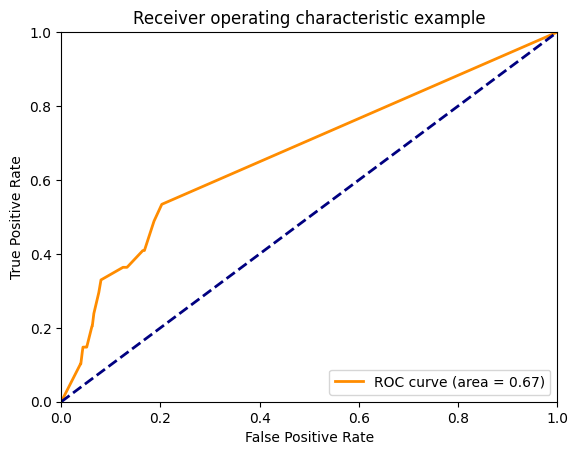

In [95]:
# Generate the prediction values for each of the test observations using predict_proba() function rather than just predict
preds = dt_clf.predict_proba(X_test)[:,1]

# Store the false positive rate(fpr), true positive rate (tpr) in vectors for use in the graph
fpr, tpr, _ = roc_curve(y_test, preds)

# Store the Area Under the Curve (AUC) so we can annotate our graph with this metric
roc_auc = auc(fpr, tpr)

# Plot the ROC Curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw = lw, label = 'ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color = 'navy', lw = lw, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc = "lower right")
plt.show()

In [275]:
# SMOTE - Synthetic Minority Oversampling Technique
# Define train and test datasets
# X_train, X_test, y_train, y_test = train_test_split(X_smote,y_smote,test_size=0.33,random_state=23)

# Define model
dt_clf = DecisionTreeClassifier()

# Fit model and predict y_pred
# LogRegCV.fit(X_train,y_train)
# y_pred_train = LogRegCV.predict(X_train)
# y_pred_test = LogRegCV.predict(X_test)

dt_clf.fit(X_rus,y_rus)
y_pred_train = dt_clf.predict(X_rus)
y_pred_test = dt_clf.predict(X_test)

# Print scores and MSE
# print("Logistic regression CV accuracy (train):",accuracy_score(y_true=y_train,y_pred=y_pred_train))
# print("Logistic regression CV accuracy (test):",accuracy_score(y_true=y_test,y_pred=y_pred_test))
# print("Logistic regression CV f1_score (train):",f1_score(y_true=y_train,y_pred=y_pred_train))
# print("Logistic regression CV f1_score (test):",f1_score(y_true=y_test,y_pred=y_pred_test))

print("Logistic regression CV accuracy (train):",accuracy_score(y_true=y_rus,y_pred=y_pred_train))
print("Logistic regression CV accuracy (test):",accuracy_score(y_true=y_test,y_pred=y_pred_test))
print("Logistic regression CV f1_score (train):",f1_score(y_true=y_rus,y_pred=y_pred_train))
print("Logistic regression CV f1_score (test):",f1_score(y_true=y_test,y_pred=y_pred_test))

Logistic regression CV accuracy (train): 1.0
Logistic regression CV accuracy (test): 0.6413752222880854
Logistic regression CV f1_score (train): 1.0
Logistic regression CV f1_score (test): 0.1723666210670315


#### BaggingClassifier: df_healthcare_with_dummies

In [106]:
# Define predictor and target variables
list_pred_col = df_healthcare_with_dummies.columns.tolist()
list_pred_col.remove("stroke") # excluding target variable
list_pred_col.remove("id") # excluding as it has no effect with stroke
list_pred_col.remove("ever_married_Yes") # excluding as it has no effect with stroke
# trying rest of the features
X = df_healthcare_with_dummies[list_pred_col]
y = df_healthcare_with_dummies["stroke"]

# Define train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33,random_state=23)

# Define model
bag_clf = BaggingClassifier()

# Fit model and predict y_pred
bag_clf.fit(X_train,y_train)
y_pred_train = bag_clf.predict(X_train)
y_pred_test = bag_clf.predict(X_test)

# Print scores and MSE
print("Logistic regression CV accuracy (train):",accuracy_score(y_true=y_train,y_pred=y_pred_train))
print("Logistic regression CV accuracy (test):",accuracy_score(y_true=y_test,y_pred=y_pred_test))
print("Logistic regression CV f1_score (train):",f1_score(y_true=y_train,y_pred=y_pred_train))
print("Logistic regression CV f1_score (test):",f1_score(y_true=y_test,y_pred=y_pred_test))

Logistic regression CV accuracy (train): 0.9918200408997955
Logistic regression CV accuracy (test): 0.945465323058684
Logistic regression CV f1_score (train): 0.9047619047619047
Logistic regression CV f1_score (test): 0.08


In [107]:
dt_params = {"n_estimators":[10,20,30],"max_features":[0.25,0.5,0.75],"max_samples":[0.25,0.5,0.75]}
gs_bag = GridSearchCV(estimator=BaggingClassifier(),param_grid=dt_params,cv=10,verbose=1,n_jobs=-1,scoring="f1")
gs_bag.fit(X_train,y_train)

Fitting 10 folds for each of 27 candidates, totalling 270 fits


GridSearchCV(cv=10, estimator=BaggingClassifier(), n_jobs=-1,
             param_grid={'max_features': [0.25, 0.5, 0.75],
                         'max_samples': [0.25, 0.5, 0.75],
                         'n_estimators': [10, 20, 30]},
             scoring='f1', verbose=1)

In [108]:
gs_bag.best_params_

{'max_features': 0.5, 'max_samples': 0.75, 'n_estimators': 10}

In [114]:
gs_bag.best_score_

0.023529411764705882

In [226]:
# SMOTE - Synthetic Minority Oversampling Technique
# Define train and test datasets
# X_train, X_test, y_train, y_test = train_test_split(X_smote,y_smote,test_size=0.33,random_state=23)

# Define model
bag_clf = BaggingClassifier()

# Fit model and predict y_pred
# LogRegCV.fit(X_train,y_train)
# y_pred_train = LogRegCV.predict(X_train)
# y_pred_test = LogRegCV.predict(X_test)

bag_clf.fit(X_smote,y_smote)
y_pred_train = bag_clf.predict(X_smote)
y_pred_test = bag_clf.predict(X_test)

# Print scores and MSE
# print("Logistic regression CV accuracy (train):",accuracy_score(y_true=y_train,y_pred=y_pred_train))
# print("Logistic regression CV accuracy (test):",accuracy_score(y_true=y_test,y_pred=y_pred_test))
# print("Logistic regression CV f1_score (train):",f1_score(y_true=y_train,y_pred=y_pred_train))
# print("Logistic regression CV f1_score (test):",f1_score(y_true=y_test,y_pred=y_pred_test))

print("Logistic regression CV accuracy (train):",accuracy_score(y_true=y_smote,y_pred=y_pred_train))
print("Logistic regression CV accuracy (test):",accuracy_score(y_true=y_test,y_pred=y_pred_test))
print("Logistic regression CV f1_score (train):",f1_score(y_true=y_smote,y_pred=y_pred_train))
print("Logistic regression CV f1_score (test):",f1_score(y_true=y_test,y_pred=y_pred_test))

Logistic regression CV accuracy (train): 0.996474555487431
Logistic regression CV accuracy (test): 0.9033787788974511
Logistic regression CV f1_score (train): 0.9964696853415196
Logistic regression CV f1_score (test): 0.1890547263681592


#### RandomForestClassifier: df_healthcare_with_dummies

In [58]:
# Define predictor and target variables
list_pred_col = df_healthcare_with_dummies.columns.tolist()
list_pred_col.remove("stroke") # excluding target variable
list_pred_col.remove("id") # excluding as it has no effect with stroke
list_pred_col.remove("ever_married_Yes") # excluding as it has no effect with stroke
# trying rest of the features
X = df_healthcare_with_dummies[list_pred_col]
y = df_healthcare_with_dummies["stroke"]

# Define train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33,random_state=23)

# Define model
randf_clf = RandomForestClassifier()

# Fit model and predict y_pred
randf_clf.fit(X_train,y_train)
y_pred_train = randf_clf.predict(X_train)
y_pred_test = randf_clf.predict(X_test)

# Print scores and MSE
print("Logistic regression CV accuracy (train):",accuracy_score(y_true=y_train,y_pred=y_pred_train))
print("Logistic regression CV accuracy (test):",accuracy_score(y_true=y_test,y_pred=y_pred_test))
print("Logistic regression CV f1_score (train):",f1_score(y_true=y_train,y_pred=y_pred_train))
print("Logistic regression CV f1_score (test):",f1_score(y_true=y_test,y_pred=y_pred_test))

Logistic regression CV accuracy (train): 1.0
Logistic regression CV accuracy (test): 0.946058091286307
Logistic regression CV f1_score (train): 1.0
Logistic regression CV f1_score (test): 0.0


In [59]:
confusion_matrix(y_true=y_train,y_pred=y_pred_train)

array([[3262,    0],
       [   0,  161]], dtype=int64)

In [60]:
confusion_matrix(y_true=y_test,y_pred=y_pred_test)

array([[1596,    3],
       [  88,    0]], dtype=int64)

In [63]:
dt_params = {"criterion":["gini","entropy","log_loss"],"max_depth":[2,3,4,5,6,7,8,9,10,12],"min_samples_split":[10,20,30,40,50],"max_features":["sqrt","log2",None]}
gs_randf = GridSearchCV(estimator=RandomForestClassifier(),param_grid=dt_params,cv=5,verbose=1,n_jobs=-1,scoring="f1")
gs_randf.fit(X_rus,y_rus)

Fitting 5 folds for each of 450 candidates, totalling 2250 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 12],
                         'max_features': ['sqrt', 'log2', None],
                         'min_samples_split': [10, 20, 30, 40, 50]},
             scoring='f1', verbose=1)

In [64]:
gs_randf.best_params_

{'criterion': 'gini',
 'max_depth': 9,
 'max_features': None,
 'min_samples_split': 10}

In [65]:
gs_randf.best_score_

0.023232323232323233

In [271]:
# SMOTE - Synthetic Minority Oversampling Technique
# Define train and test datasets
# X_train, X_test, y_train, y_test = train_test_split(X_smote,y_smote,test_size=0.33,random_state=23)

# Define model
randf_clf = RandomForestClassifier()

# Fit model and predict y_pred
# LogRegCV.fit(X_train,y_train)
# y_pred_train = LogRegCV.predict(X_train)
# y_pred_test = LogRegCV.predict(X_test)

randf_clf.fit(X_rus,y_rus)
y_pred_train = randf_clf.predict(X_rus)
y_pred_test = randf_clf.predict(X_test)

# Print scores and MSE
# print("Logistic regression CV accuracy (train):",accuracy_score(y_true=y_train,y_pred=y_pred_train))
# print("Logistic regression CV accuracy (test):",accuracy_score(y_true=y_test,y_pred=y_pred_test))
# print("Logistic regression CV f1_score (train):",f1_score(y_true=y_train,y_pred=y_pred_train))
# print("Logistic regression CV f1_score (test):",f1_score(y_true=y_test,y_pred=y_pred_test))

print("Logistic regression CV accuracy (train):",accuracy_score(y_true=y_rus,y_pred=y_pred_train))
print("Logistic regression CV accuracy (test):",accuracy_score(y_true=y_test,y_pred=y_pred_test))
print("Logistic regression CV f1_score (train):",f1_score(y_true=y_rus,y_pred=y_pred_train))
print("Logistic regression CV f1_score (test):",f1_score(y_true=y_test,y_pred=y_pred_test))

Logistic regression CV accuracy (train): 1.0
Logistic regression CV accuracy (test): 0.6965026674570243
Logistic regression CV f1_score (train): 1.0
Logistic regression CV f1_score (test): 0.21951219512195125


## Deliver
1. Visualization
2. Summarise: Which model is optimal?

In [193]:
model_results

{'Model': ['LinearRegression', 'RidgeCV', 'LassoCV'],
 'Score': [0.6375890682042074, 0.6375890682131082, 0.6375890682045731],
 'MSE': [4861743844.573455, 4861743844.454048, 4861743844.454048]}

In [194]:
df_results = pd.DataFrame(model_results)
df_results

Model     Score           MSE
0  LinearRegression  0.637589  4.861744e+09
1           RidgeCV  0.637589  4.861744e+09
2           LassoCV  0.637589  4.861744e+09

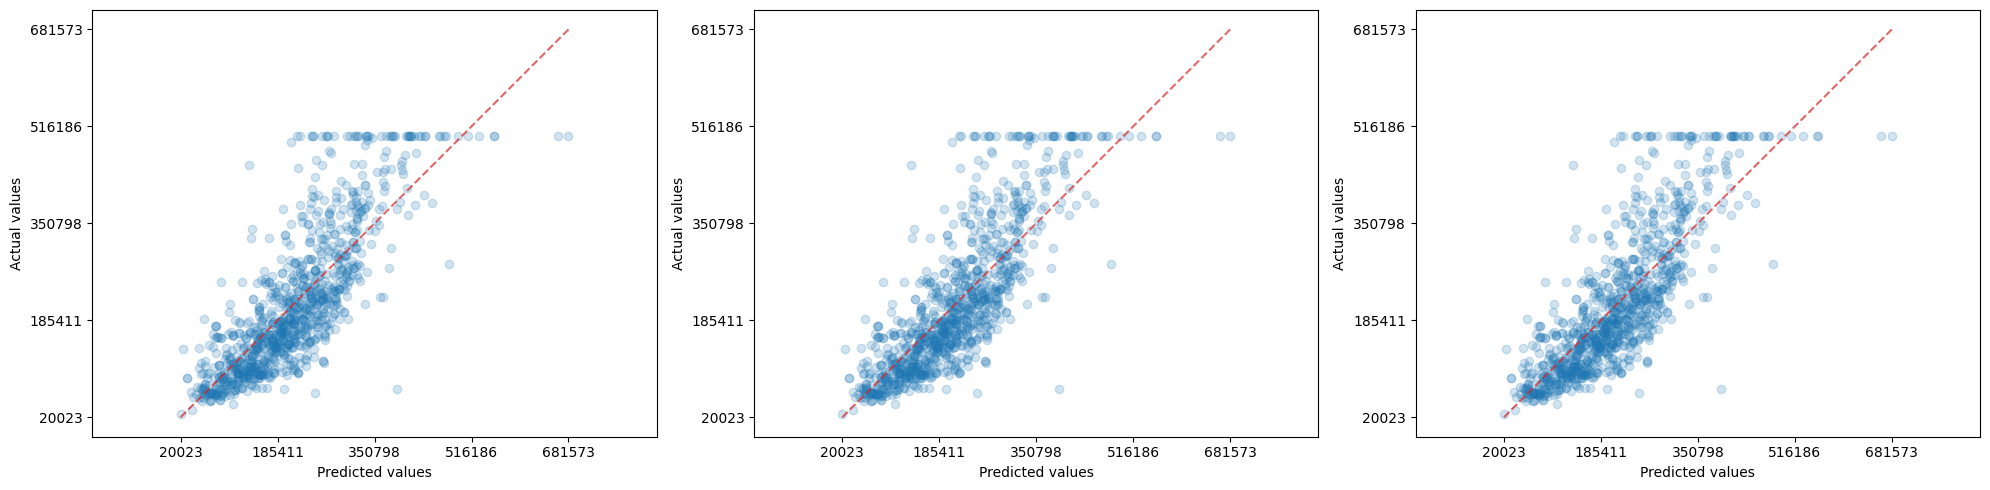

In [200]:
# Model evaluation
fig, axs = plt.subplots(1,3, figsize=(20,5))
axs = np.ravel(axs)
list_y_pred = [y_pred_test,y_pred_ridge,y_pred_lasso]
for ax,y_pred in zip(axs,list_y_pred):
    display = PredictionErrorDisplay.from_predictions(y_pred=y_pred,y_true=y_test,kind="actual_vs_predicted",scatter_kwargs={"alpha": 0.2, "color": "tab:blue"},
            line_kwargs={"color": "tab:red"},ax=ax,random_state=23)
plt.tight_layout()
plt.show()

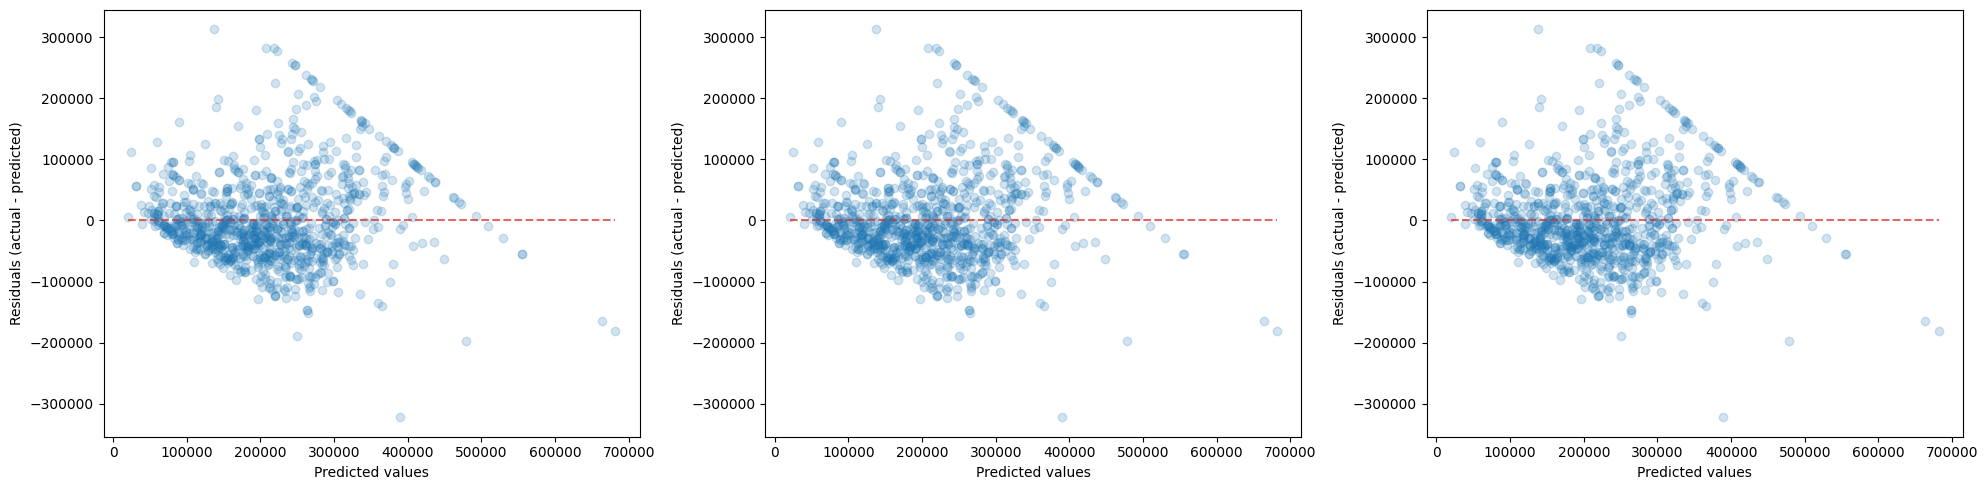

In [201]:
fig, axs = plt.subplots(1,3, figsize=(20,5))
axs = np.ravel(axs)
list_y_pred = [y_pred_test,y_pred_ridge,y_pred_lasso]
for ax,y_pred in zip(axs,list_y_pred):
    display = PredictionErrorDisplay.from_predictions(y_pred=y_pred,y_true=y_test,kind="residual_vs_predicted",scatter_kwargs={"alpha": 0.2, "color": "tab:blue"},
            line_kwargs={"color": "tab:red"},ax=ax,random_state=23)
plt.tight_layout()
plt.show()

## TEST

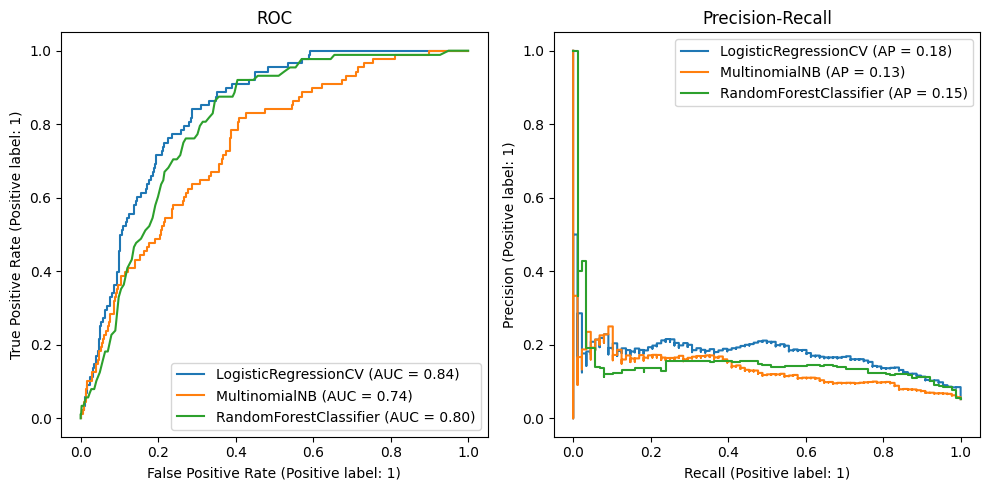

In [10]:
# Define predictor and target variables
list_pred_col = df_healthcare_with_dummies.columns.tolist()
list_pred_col.remove("stroke") # excluding target variable
list_pred_col.remove("id") # excluding as it has no effect with stroke
list_pred_col.remove("ever_married_Yes") # excluding as it has no effect with stroke
# trying rest of the features
X = df_healthcare_with_dummies[list_pred_col]
y = df_healthcare_with_dummies["stroke"]

# Define train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33,random_state=23)

rus = RandomUnderSampler(random_state=23)
X_rus, y_rus = rus.fit_resample(X_train,y_train)

LogRegCV = LogisticRegressionCV(Cs=[1, 10, 100],cv=10,solver="newton-cholesky")
LogRegCV.fit(X_rus,y_rus)
mnb = MultinomialNB()
mnb.fit(X_rus,y_rus)
randf_clf = RandomForestClassifier()
randf_clf.fit(X_rus,y_rus)

fig, axs = plt.subplots(1,2,figsize=(10,5))
RocCurveDisplay.from_estimator(LogRegCV,X=X_test,y=y_test,ax=axs[0])
RocCurveDisplay.from_estimator(mnb,X=X_test,y=y_test,ax=axs[0])
RocCurveDisplay.from_estimator(randf_clf,X=X_test,y=y_test,ax=axs[0])
axs[0].set_title("ROC")
PrecisionRecallDisplay.from_estimator(LogRegCV,X=X_test,y=y_test,ax=axs[1])
PrecisionRecallDisplay.from_estimator(mnb,X=X_test,y=y_test,ax=axs[1])
PrecisionRecallDisplay.from_estimator(randf_clf,X=X_test,y=y_test,ax=axs[1])
axs[1].set_title("Precision-Recall")
axs[1].legend(loc="upper right")
plt.tight_layout()
plt.show()

In [13]:
pickle.dump(LogRegCV, open('LogRegCV.pkl', 'wb'))
pickle.dump(mnb, open('MNB.pkl', 'wb'))
pickle.dump(randf_clf, open('randf_clf.pkl', 'wb'))

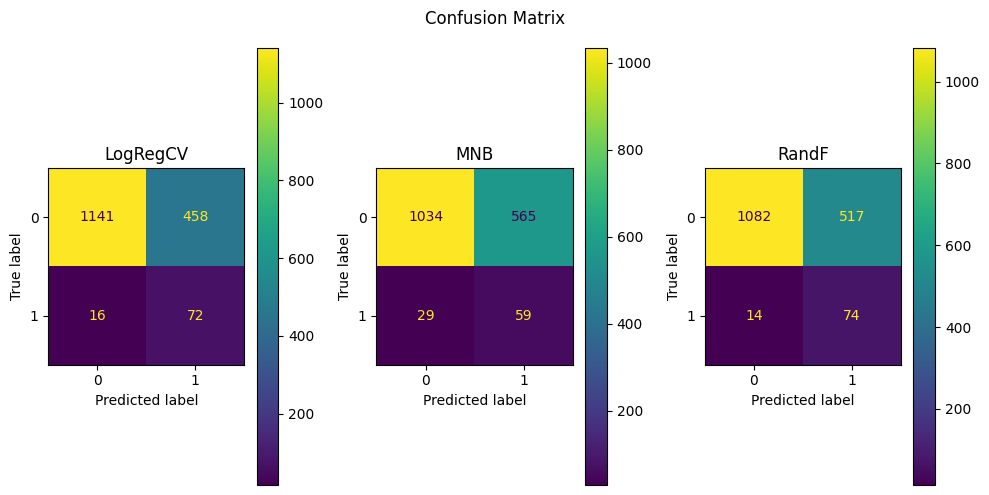

In [322]:
fig, axs = plt.subplots(1,3,figsize=(10,5))
ConfusionMatrixDisplay.from_estimator(LogRegCV,X=X_test,y=y_test,ax=axs[0])
axs[0].set_title("LogRegCV")
ConfusionMatrixDisplay.from_estimator(mnb,X=X_test,y=y_test,ax=axs[1])
axs[1].set_title("MNB")
ConfusionMatrixDisplay.from_estimator(randf_clf,X=X_test,y=y_test,ax=axs[2])
axs[2].set_title("RandF")
plt.suptitle("Confusion Matrix")
plt.tight_layout()
plt.show()

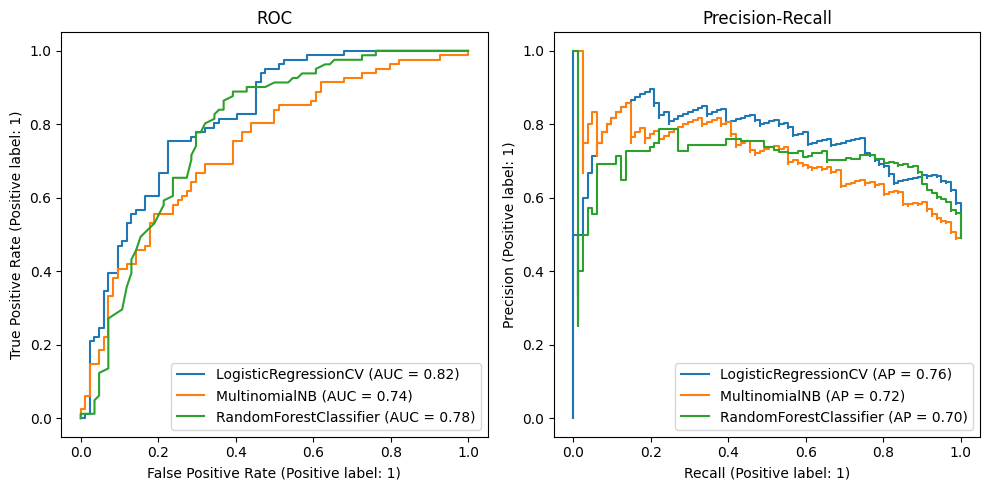

In [323]:
# Define predictor and target variables
list_pred_col = df_healthcare_with_dummies.columns.tolist()
list_pred_col.remove("stroke") # excluding target variable
list_pred_col.remove("id") # excluding as it has no effect with stroke
list_pred_col.remove("ever_married_Yes") # excluding as it has no effect with stroke
# trying rest of the features
X = df_healthcare_with_dummies[list_pred_col]
y = df_healthcare_with_dummies["stroke"]

rus = RandomUnderSampler(random_state=23)
X_rus, y_rus = rus.fit_resample(X,y)

# Define train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X_rus,y_rus,test_size=0.33,random_state=23)

LogRegCV = LogisticRegressionCV(Cs=[1, 10, 100],cv=10,solver="newton-cholesky")
LogRegCV.fit(X_train,y_train)
mnb = MultinomialNB()
mnb.fit(X_train,y_train)
randf_clf = RandomForestClassifier()
randf_clf.fit(X_train,y_train)

fig, axs = plt.subplots(1,2,figsize=(10,5))
RocCurveDisplay.from_estimator(LogRegCV,X=X_test,y=y_test,ax=axs[0])
RocCurveDisplay.from_estimator(mnb,X=X_test,y=y_test,ax=axs[0])
RocCurveDisplay.from_estimator(randf_clf,X=X_test,y=y_test,ax=axs[0])
axs[0].set_title("ROC")
PrecisionRecallDisplay.from_estimator(LogRegCV,X=X_test,y=y_test,ax=axs[1])
PrecisionRecallDisplay.from_estimator(mnb,X=X_test,y=y_test,ax=axs[1])
PrecisionRecallDisplay.from_estimator(randf_clf,X=X_test,y=y_test,ax=axs[1])
axs[1].set_title("Precision-Recall")
axs[1].legend(loc="lower right")
plt.tight_layout()
plt.show()

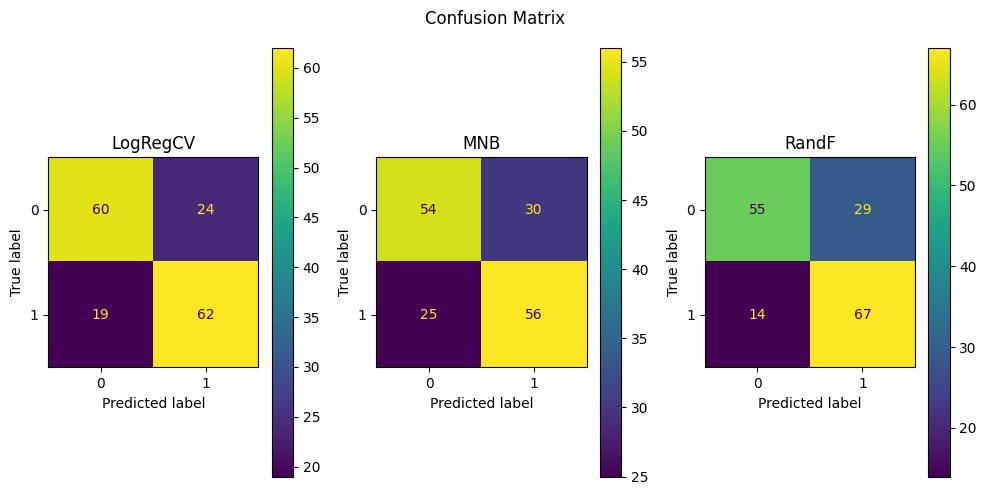

In [324]:
fig, axs = plt.subplots(1,3,figsize=(10,5))
ConfusionMatrixDisplay.from_estimator(LogRegCV,X=X_test,y=y_test,ax=axs[0])
axs[0].set_title("LogRegCV")
ConfusionMatrixDisplay.from_estimator(mnb,X=X_test,y=y_test,ax=axs[1])
axs[1].set_title("MNB")
ConfusionMatrixDisplay.from_estimator(randf_clf,X=X_test,y=y_test,ax=axs[2])
axs[2].set_title("RandF")
plt.suptitle("Confusion Matrix")
plt.tight_layout()
plt.show()

In [ ]:
import time

from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay
from sklearn.model_selection import cross_val_predict, cross_validate

# Define predictor and target variables
list_pred_col = df_healthcare_with_dummies.columns.tolist()
list_pred_col.remove("stroke") # excluding target variable
list_pred_col.remove("id") # excluding as it has no effect with stroke
list_pred_col.remove("ever_married_Yes") # excluding as it has no effect with stroke
# trying rest of the features
X = df_healthcare_with_dummies[list_pred_col]
y = df_healthcare_with_dummies["stroke"]

# Define train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33,random_state=23)

fig, axs = plt.subplots(1, 3, figsize=(20, 8))
axs = np.ravel(axs)

estimators = [
    ("LogisticRegressionCV", LogRegCV = LogisticRegressionCV(Cs=[1, 10, 100],cv=10,solver="newton-cholesky")),
    ("MultinomialNB", MultinomialNB(alpha=0.3511191734215131)),
    ("RandomForest", RandomForestClassifier()),
]

for ax, (name, est) in zip(axs, estimators):
    
    scorers = {"Acc": "accuracy_score", "F1": "f1_score"}

    start_time = time.time()
    scores = cross_validate(
        est, X_rus, y_rus, scoring=list(scorers.values()), n_jobs=-1, verbose=0
    )
    elapsed_time = time.time() - start_time

    y_pred = cross_val_predict(est, X_rus, y_rus, n_jobs=-1, verbose=0)
    scores = {
        key: (
            f"{np.abs(np.mean(scores[f'test_{value}'])):.2f} +- "
            f"{np.std(scores[f'test_{value}']):.2f}"
        )
        for key, value in scorers.items()
    }

    display = PredictionErrorDisplay.from_predictions(
        y_true=y_train,
        y_pred=y_pred,
        kind="actual_vs_predicted",
        ax=ax,
        scatter_kwargs={"alpha": 0.2, "color": "tab:blue"},
        line_kwargs={"color": "tab:red"},
        # random_state=23
    )
    ax.set_title(f"{name}\nEvaluation in {elapsed_time:.2f} seconds")

    for name, score in scores.items():
        ax.plot([], [], " ", label=f"{name}: {score}")
    ax.legend(loc="upper left")

plt.suptitle("LinearRegression vs RidgeCV vs LassoCV")
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()